## 1) Kurulum 




In [1]:
import sys
print("python:", sys.version)
print("exe:", sys.executable)

try:
    import cv2
    print("cv2 ok:", cv2.__version__)
except Exception as e:
    print("cv2 FAIL:", type(e).__name__, e)

try:
    import mediapipe as mp
    print("mp ok:", mp.__file__)
    print("has solutions:", hasattr(mp, "solutions"))
except Exception as e:
    print("mp FAIL:", type(e).__name__, e)

python: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.4.4.1)]
exe: /Users/mehmetatahankulekci/Desktop/deneme/.venv312/bin/python
cv2 ok: 4.11.0
mp ok: /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/mediapipe/__init__.py
has solutions: True


In [2]:
import sys
import subprocess
import importlib

print("Python:", sys.version.split()[0])
print("Executable:", sys.executable)

# --- Paket kurulumu (aktif kernel'e kurar) ---
base_pkgs = [
    # mediapipe==0.10.20 numpy<2 ister; numpy'yi pinliyoruz ki opencv kurarken 2.x'e zıplamasın.
    "numpy==1.26.4",
    "pandas",
    "scipy",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "tqdm",
]
raw_pkgs = [
    # opencv-python 4.12+ numpy>=2 istiyor; mediapipe==0.10.20 ise numpy 1.26.x ile geliyor.
    # Bu yüzden opencv-contrib-python 4.11.x ile pinliyoruz (cv2 sağlar).
    "opencv-contrib-python==4.11.0.86",
    # Bu notebook `mp.solutions.pose/hands` kullandığı için solutions içeren sürüm:
    "mediapipe==0.10.20",
]

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])

pkgs = list(base_pkgs)
if sys.version_info >= (3, 13):
    # MediaPipe genelde 3.13'te sorun çıkarıyor.
    print("⚠️ Python 3.13 tespit edildi. mediapipe bu sürümde çalışmayabilir.")
    print("   Çözüm: Kernel'i Python 3.12/3.11'e geçir.")
else:
    pkgs += raw_pkgs

subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])

# --- Hızlı doğrulama ---
checks = [
    "numpy",
    "pandas",
    "scipy",
    "sklearn",
    "matplotlib",
    "seaborn",
    "tqdm",
    "cv2",
    "mediapipe",
]
for name in checks:
    try:
        mod = importlib.import_module(name)
        ver = getattr(mod, "__version__", "(no __version__)")
        path = getattr(mod, "__file__", "(built-in)")
        print(f"✅ {name}: {ver}  @  {path}")
    except Exception as e:
        print(f"❌ {name}: {type(e).__name__}: {e}")

# mediapipe sanity
try:
    import mediapipe as _mp
    print("mediapipe has solutions:", hasattr(_mp, "solutions"))
    if not hasattr(_mp, "solutions"):
        print("⚠️  Bu genelde yanlış/bozuk mediapipe kurulumu veya isim çakışması demek.")
        print("   mediapipe imported from:", getattr(_mp, "__file__", "(built-in)"))
except Exception as e:
    print("mediapipe check failed:", type(e).__name__, e)


Python: 3.12.12
Executable: /Users/mehmetatahankulekci/Desktop/deneme/.venv312/bin/python
✅ numpy: 1.26.4  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/numpy/__init__.py
✅ pandas: 2.3.3  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/pandas/__init__.py
✅ scipy: 1.17.0  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/scipy/__init__.py
✅ sklearn: 1.8.0  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/__init__.py
✅ matplotlib: 3.10.8  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/matplotlib/__init__.py
✅ seaborn: 0.13.2  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/seaborn/__init__.py
✅ tqdm: 4.67.1  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/tqdm/__init__.py
✅ cv2: 4.11.0  @  /Users/mehmetatahankulekci/Desktop/deneme/.venv312

In [3]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.io as sio

# === Opsiyonel: RAW görsellerden landmark çıkarımı için ===
try:
    import cv2
except ImportError:  # notebook "mat" modunda çalışsın diye opsiyonel
    cv2 = None

# mediapipe bazı ortamlarda import olsa bile `mp.solutions` içermeyebilir (özellikle tasks-only build).
# Bu notebook `mp.solutions.pose/hands` kullandığı için solutions olmayan sürümle RAW mode çalışmaz.
try:
    import importlib, importlib.util
    import mediapipe as mp

    if not hasattr(mp, "solutions"):
        # Bazı sürümlerde solutions ayrı modül olarak var olabilir
        spec = importlib.util.find_spec("mediapipe.python.solutions")
        if spec is not None:
            from mediapipe.python import solutions as _solutions
            mp.solutions = _solutions

    if not hasattr(mp, "solutions"):
        # Hâlâ yoksa: muhtemelen tasks-only build. Otomatik olarak solutions içeren sürüme düşür.
        try:
            import sys, subprocess
            if globals().get("AUTO_INSTALL_RAW_DEPS", False) and sys.version_info < (3, 13):
                print("⚙️  mediapipe kurulu ama `mp.solutions` yok (tasks-only build olabilir).")
                print("   ➜ `mediapipe==0.10.20` kurmayı deniyorum...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--force-reinstall", "numpy==1.26.4", "mediapipe==0.10.20"])
                importlib.invalidate_caches()
                mp = importlib.reload(mp)

                spec = importlib.util.find_spec("mediapipe.python.solutions")
                if spec is not None and not hasattr(mp, "solutions"):
                    from mediapipe.python import solutions as _solutions
                    mp.solutions = _solutions
        except Exception as _e:
            print("⚠️  mediapipe downgrade denemesi başarısız:", type(_e).__name__, _e)

    if not hasattr(mp, "solutions"):
        mp = None
        print("⚠️  mediapipe import edildi ama `mp.solutions` hâlâ yok.")
        print("   Bu notebook RAW mode için solutions API ister.")
        print("   Çözüm: kernel 3.11/3.12 iken `pip install opencv-contrib-python==4.11.0.86 mediapipe==0.10.20` çalıştır.")

except ImportError:  # notebook "mat" modunda çalışsın diye opsiyonel
    mp = None

try:
    from tqdm.auto import tqdm
except ImportError:
    tqdm = None

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import mediapipe as mp
print(mp.__version__)
print("has mp.solutions:", hasattr(mp, "solutions"))

0.10.20
has mp.solutions: True


In [5]:
# === ÇALIŞMA MODU ===
# - "mat": MEED gibi hazır koordinat (.mat) dosyalarıyla (SADECE VÜCUT, 25 nokta OpenPose BODY_25)
# - "raw_images": ham görsellerden MediaPipe (VÜCUT + ELLER, pose 33 + left hand 21 + right hand 21)
DATA_MODE = "raw_images"  # "mat" | "raw_images" ← ŞİMDİ RAW IMAGES KULLANIYORUZ!

# === MAT modu ayarları ===
DATA_DIR = r"/Users/mehmetatahankulekci/Desktop/neural network project/real raw data"

# === RAW-IMG modu ayarları (ŞİMDİ AKTİF!) ===
# ZIP'lerin olduğu klasör (sadece .zip'ler taranır):
ZIP_SOURCE_DIR = r"/Users/mehmetatahankulekci/Desktop/neural network project/real raw data"
# Çıkartılacak yer:
RAW_DATA_DIR = r"/Users/mehmetatahankulekci/Desktop/neural network project/real raw data"
TARGET_FRAMES = 97  # her clip'i 97 frame'e sample/pad edeceğiz

# Hangi view'lar var?
AVAILABLE_VIEWS = ["front", "right"]  # left yok!

# Schema belirleme
# "openpose25" → .mat (25 nokta, sadece vücut)
# "mp_pose_hands" → raw images (33 pose + 42 hands = 75 nokta + face placeholder)
SCHEMA = "openpose25" if DATA_MODE == "mat" else "mp_pose_hands"

# Yüz: MediaPipe'tan face çıkarımı YAPILMIYOR
# İstersen model input'unda placeholder olarak 0 ekleyebilirsin
INCLUDE_FACE_PLACEHOLDER = True
N_FACE_LANDMARKS = 468

# RAW mode'da eksik paketleri (cv2/mediapipe) otomatik kurmayı denesin mi?
AUTO_INSTALL_RAW_DEPS = True

print("="*60)
print("⚙️  CONFIGURATION")
print("="*60)
print(f"DATA_MODE: {DATA_MODE}")
print(f"SCHEMA: {SCHEMA}")
if DATA_MODE == "mat":
    print(f"DATA_DIR: {DATA_DIR}")
    print(f"VIEWS: front + left + right (multi-view) ✅")
    print(f"Expected feature size: 50 × 3 = 150 features")
    print("\n⚠️  Not: .mat dosyaları SADECE VÜCUT noktaları içerir (25 nokta, eller yok)")
    print("   Raw data gelince DATA_MODE='raw_images' yaparak VÜCUT + ELLER kullanabilirsin")
else:
    print(f"RAW_DATA_DIR: {RAW_DATA_DIR}")
    print(f"Exists? {os.path.exists(RAW_DATA_DIR)}")
    print(f"Target frames: {TARGET_FRAMES}")
    print("\n✅ MediaPipe ile VÜCUT (33) + ELLER (42) = 75 nokta çıkarılacak")
print("="*60)


⚙️  CONFIGURATION
DATA_MODE: raw_images
SCHEMA: mp_pose_hands
RAW_DATA_DIR: /Users/mehmetatahankulekci/Desktop/neural network project/real raw data
Exists? True
Target frames: 97

✅ MediaPipe ile VÜCUT (33) + ELLER (42) = 75 nokta çıkarılacak


## 2) ZIP Extraction & MediaPipe Processing (Raw Data)




In [6]:
if DATA_MODE == "raw_images":
    import zipfile
    from pathlib import Path

    print("="*80)
    print("RAW DATA PROCESSING: ZIP EXTRACTION")
    print("="*80)

    zip_dir = Path(ZIP_SOURCE_DIR)
    out_root = Path(RAW_DATA_DIR)
    out_root.mkdir(parents=True, exist_ok=True)

    # Sadece .zip dosyalarını aç
    all_zips = sorted([p for p in zip_dir.iterdir() if p.is_file() and p.suffix.lower() == ".zip"])

    print(f"ZIP_SOURCE_DIR: {zip_dir}  (found {len(all_zips)} zip)")
    print(f"RAW_DATA_DIR:   {out_root}")
    print("-"*80)

    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

    def _has_any_images(root: Path) -> bool:
        root = Path(root)
        if not root.exists():
            return False
        for p in root.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                return True
        return False

    def _safe_extract_zip(zip_path: Path, out_root: Path, overwrite: bool = False):
        """Extract a zip into RAW_DATA_DIR.

        - Eğer zip'in içeriği tek bir top-level klasör altında ise: out_root içine extract eder.
          (skip kontrolü: out_root/<top_level> gerçekten dolu mu?)
        - Değilse: out_root/<zip_stem>/ altına extract eder.
        """
        with zipfile.ZipFile(zip_path, "r") as zf:
            members = [n for n in zf.namelist() if n and not n.endswith("/")]
            if not members:
                print(f"   ⚠️  {zip_path.name}: empty zip, skipping.")
                return "empty"

            top_levels = {m.split("/")[0] for m in members if "/" in m}
            single_top = (len(top_levels) == 1)

            if single_top:
                top = next(iter(top_levels))
                expected_root = out_root / top
                target_dir = out_root
            else:
                expected_root = out_root / zip_path.stem
                target_dir = expected_root

            # ✅ Doğru skip kriteri: bu zip'e ait beklenen root gerçekten dolu mu?
            if not overwrite and _has_any_images(expected_root):
                print(f"   ✓ {zip_path.name}: already extracted (found images under {expected_root.name}), skipping.")
                return "skipped"

            target_dir.mkdir(parents=True, exist_ok=True)
            print(f"   ⏳ Extracting {zip_path.name} -> {target_dir}")
            zf.extractall(target_dir)

            # Extract sonrası doğrula
            if _has_any_images(expected_root):
                print(f"   ✅ Done: {zip_path.name}")
                return "extracted"
            else:
                print(f"   ⚠️  {zip_path.name}: extracted but no images found under {expected_root} (zip content farklı olabilir)")
                return "no_images"

    stats = {"extracted": 0, "skipped": 0, "empty": 0, "no_images": 0}
    for zp in all_zips:
        r = _safe_extract_zip(zp, out_root, overwrite=False)
        if r in stats:
            stats[r] += 1

    print("-"*80)
    print(f"✅ ZIP extraction complete. Output: {out_root}")
    print(f"Stats: {stats}")
    print("="*80)
else:
    print("Skipping ZIP extraction (DATA_MODE != 'raw_images')")


RAW DATA PROCESSING: ZIP EXTRACTION
ZIP_SOURCE_DIR: /Users/mehmetatahankulekci/Desktop/neural network project/real raw data  (found 0 zip)
RAW_DATA_DIR:   /Users/mehmetatahankulekci/Desktop/neural network project/real raw data
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
✅ ZIP extraction complete. Output: /Users/mehmetatahankulekci/Desktop/neural network project/real raw data
Stats: {'extracted': 0, 'skipped': 0, 'empty': 0, 'no_images': 0}


## 2) Feature 


In [7]:
# ============================================================================
# MODEL 2 FEATURE EXTRACTION
# ============================================================================
# 0) Normalizasyon (merkezleme + ölçekleme)
# 1) Statik postür: gövde eğimi, omuz/kalça seviye farkı, kol açıklığı, vb.
# 2) Eklem açıları: dirsek, diz
# 3) Hareket (motion): bilek/omuz/gövde hızları
# 4) Simetri: sol-sağ farkları
# 5) Confidence özeti

EPS = 1e-6

# === OpenPose BODY_25 indexleri (MEED .mat) ===
OP_NOSE = 0
OP_NECK = 1
OP_R_SHO, OP_L_SHO = 2, 5
OP_R_ELB, OP_L_ELB = 3, 6
OP_R_WRI, OP_L_WRI = 4, 7
OP_MID_HIP = 8
OP_R_HIP, OP_L_HIP = 9, 12
OP_R_KNE, OP_L_KNE = 10, 13
OP_R_ANK, OP_L_ANK = 11, 14

# === MediaPipe Pose indexleri ===
MP_NOSE = 0
MP_L_SHO, MP_R_SHO = 11, 12
MP_L_ELB, MP_R_ELB = 13, 14
MP_L_WRI, MP_R_WRI = 15, 16
MP_L_HIP, MP_R_HIP = 23, 24
MP_L_KNE, MP_R_KNE = 25, 26
MP_L_ANK, MP_R_ANK = 27, 28


def _dist(ax, ay, bx, by):
    """Euclidean distance between two points."""
    return np.sqrt((ax - bx)**2 + (ay - by)**2)


def _angle_at_B(Ax, Ay, Bx, By, Cx, Cy):
    """Compute angle at point B for points A-B-C."""
    # Vectors BA and BC
    BAx, BAy = Ax - Bx, Ay - By
    BCx, BCy = Cx - Bx, Cy - By
    
    dot = BAx * BCx + BAy * BCy
    mag_BA = np.sqrt(BAx**2 + BAy**2) + EPS
    mag_BC = np.sqrt(BCx**2 + BCy**2) + EPS
    
    cos_angle = np.clip(dot / (mag_BA * mag_BC), -1.0, 1.0)
    angle = np.arccos(cos_angle)
    return angle  # radians


def _safe_mean_std(arr):
    """Return (mean, std) of array; handle empty/zero case."""
    if len(arr) == 0:
        return 0.0, 0.0
    return float(np.mean(arr)), float(np.std(arr))


def normalize_pose(X, Y, midhip_idx, lsho_idx, rsho_idx):
    """
    Normalize pose: center at MidHip, scale by shoulder width.
    Returns: X_norm, Y_norm, scale
    """
    T = X.shape[0]
    
    # Center
    midhip_x = X[:, midhip_idx]
    midhip_y = Y[:, midhip_idx]
    X_centered = X - midhip_x[:, None]
    Y_centered = Y - midhip_y[:, None]
    
    # Scale by shoulder width
    lsho_x, lsho_y = X_centered[:, lsho_idx], Y_centered[:, lsho_idx]
    rsho_x, rsho_y = X_centered[:, rsho_idx], Y_centered[:, rsho_idx]
    shoulder_width = _dist(lsho_x, lsho_y, rsho_x, rsho_y) + EPS
    
    X_norm = X_centered / shoulder_width[:, None]
    Y_norm = Y_centered / shoulder_width[:, None]
    
    return X_norm, Y_norm, shoulder_width


def extract_features_openpose25(X, Y, C):
    """
    Extract all features for OpenPose BODY_25 schema.
    X, Y, C: (T, 25)
    Returns: 1D feature vector
    """
    T = X.shape[0]
    feats = []
    
    # === 0) NORMALIZASYON ===
    X_n, Y_n, scale = normalize_pose(X, Y, OP_MID_HIP, OP_L_SHO, OP_R_SHO)
    
    # === 1) STATIK POSTÜR FEATURES ===
    # A) Gövde ve duruş
    # Torso tilt: Neck - MidHip vektörünün açısı
    neck_x, neck_y = X_n[:, OP_NECK], Y_n[:, OP_NECK]
    midhip_x, midhip_y = X_n[:, OP_MID_HIP], Y_n[:, OP_MID_HIP]
    torso_angle = np.arctan2(neck_y - midhip_y, neck_x - midhip_x)
    
    # Omuz seviye farkı
    lsho_y, rsho_y = Y_n[:, OP_L_SHO], Y_n[:, OP_R_SHO]
    shoulder_level_diff = np.abs(lsho_y - rsho_y)
    
    # Kalça seviye farkı
    lhip_y, rhip_y = Y_n[:, OP_L_HIP], Y_n[:, OP_R_HIP]
    hip_level_diff = np.abs(lhip_y - rhip_y)
    
    feats.extend([*_safe_mean_std(torso_angle)])
    feats.extend([*_safe_mean_std(shoulder_level_diff)])
    feats.extend([*_safe_mean_std(hip_level_diff)])
    
    # B) Kapalı mı açık mı?
    # Kol açıklığı
    lwri_x, lwri_y = X_n[:, OP_L_WRI], Y_n[:, OP_L_WRI]
    rwri_x, rwri_y = X_n[:, OP_R_WRI], Y_n[:, OP_R_WRI]
    arm_openness = _dist(lwri_x, lwri_y, rwri_x, rwri_y)
    
    # Dirseklerin gövdeye yakınlığı
    lelb_x, lelb_y = X_n[:, OP_L_ELB], Y_n[:, OP_L_ELB]
    relb_x, relb_y = X_n[:, OP_R_ELB], Y_n[:, OP_R_ELB]
    lelb_to_midhip = _dist(lelb_x, lelb_y, midhip_x, midhip_y)
    relb_to_midhip = _dist(relb_x, relb_y, midhip_x, midhip_y)
    
    # Bileklerin kalçaya yakınlığı
    lhip_x, lhip_y = X_n[:, OP_L_HIP], Y_n[:, OP_L_HIP]
    rhip_x, rhip_y = X_n[:, OP_R_HIP], Y_n[:, OP_R_HIP]
    lwri_to_lhip = _dist(lwri_x, lwri_y, lhip_x, lhip_y)
    rwri_to_rhip = _dist(rwri_x, rwri_y, rhip_x, rhip_y)
    
    feats.extend([*_safe_mean_std(arm_openness)])
    feats.extend([*_safe_mean_std(lelb_to_midhip)])
    feats.extend([*_safe_mean_std(relb_to_midhip)])
    feats.extend([*_safe_mean_std(lwri_to_lhip)])
    feats.extend([*_safe_mean_std(rwri_to_rhip)])
    
    # C) Baş/üst gövde
    nose_x, nose_y = X_n[:, OP_NOSE], Y_n[:, OP_NOSE]
    head_neck_dist = _dist(nose_x, nose_y, neck_x, neck_y)
    head_x_pos = nose_x - midhip_x
    head_y_pos = nose_y - midhip_y
    
    feats.extend([*_safe_mean_std(head_neck_dist)])
    feats.extend([*_safe_mean_std(head_x_pos)])
    feats.extend([*_safe_mean_std(head_y_pos)])
    
    # === 2) EKLEM AÇILARI ===
    lsho_x, lsho_y = X_n[:, OP_L_SHO], Y_n[:, OP_L_SHO]
    rsho_x, rsho_y = X_n[:, OP_R_SHO], Y_n[:, OP_R_SHO]
    
    # Sol dirsek açısı: LShoulder - LElbow - LWrist
    left_elbow_angle = _angle_at_B(lsho_x, lsho_y, lelb_x, lelb_y, lwri_x, lwri_y)
    
    # Sağ dirsek açısı
    right_elbow_angle = _angle_at_B(rsho_x, rsho_y, relb_x, relb_y, rwri_x, rwri_y)
    
    # Sol diz açısı: LHip - LKnee - LAnkle
    lkne_x, lkne_y = X_n[:, OP_L_KNE], Y_n[:, OP_L_KNE]
    lank_x, lank_y = X_n[:, OP_L_ANK], Y_n[:, OP_L_ANK]
    left_knee_angle = _angle_at_B(lhip_x, lhip_y, lkne_x, lkne_y, lank_x, lank_y)
    
    # Sağ diz açısı
    rkne_x, rkne_y = X_n[:, OP_R_KNE], Y_n[:, OP_R_KNE]
    rank_x, rank_y = X_n[:, OP_R_ANK], Y_n[:, OP_R_ANK]
    right_knee_angle = _angle_at_B(rhip_x, rhip_y, rkne_x, rkne_y, rank_x, rank_y)
    
    feats.extend([*_safe_mean_std(left_elbow_angle)])
    feats.extend([*_safe_mean_std(right_elbow_angle)])
    feats.extend([*_safe_mean_std(left_knee_angle)])
    feats.extend([*_safe_mean_std(right_knee_angle)])
    
    # === 3) HAREKET (MOTION) FEATURES ===
    # Hız = frame-to-frame fark
    lwri_vel = np.sqrt(np.diff(lwri_x, prepend=lwri_x[0])**2 + np.diff(lwri_y, prepend=lwri_y[0])**2)
    rwri_vel = np.sqrt(np.diff(rwri_x, prepend=rwri_x[0])**2 + np.diff(rwri_y, prepend=rwri_y[0])**2)
    lsho_vel = np.sqrt(np.diff(lsho_x, prepend=lsho_x[0])**2 + np.diff(lsho_y, prepend=lsho_y[0])**2)
    rsho_vel = np.sqrt(np.diff(rsho_x, prepend=rsho_x[0])**2 + np.diff(rsho_y, prepend=rsho_y[0])**2)
    midhip_vel = np.sqrt(np.diff(midhip_x, prepend=midhip_x[0])**2 + np.diff(midhip_y, prepend=midhip_y[0])**2)
    torso_tilt_change = np.abs(np.diff(torso_angle, prepend=torso_angle[0]))
    
    feats.extend([*_safe_mean_std(lwri_vel)])
    feats.extend([*_safe_mean_std(rwri_vel)])
    feats.extend([*_safe_mean_std(lsho_vel)])
    feats.extend([*_safe_mean_std(rsho_vel)])
    feats.extend([*_safe_mean_std(midhip_vel)])
    feats.extend([*_safe_mean_std(torso_tilt_change)])
    
    # === 4) SİMETRİ FEATURES ===
    elbow_angle_diff = np.abs(left_elbow_angle - right_elbow_angle)
    knee_angle_diff = np.abs(left_knee_angle - right_knee_angle)
    wrist_to_midhip_diff = np.abs(
        _dist(lwri_x, lwri_y, midhip_x, midhip_y) - 
        _dist(rwri_x, rwri_y, midhip_x, midhip_y)
    )
    
    feats.extend([*_safe_mean_std(elbow_angle_diff)])
    feats.extend([*_safe_mean_std(knee_angle_diff)])
    feats.extend([*_safe_mean_std(wrist_to_midhip_diff)])
    
    # === 5) CONFIDENCE FEATURES ===
    # Ortalama conf
    mean_conf = C.mean()
    
    # Kritik noktaların conf'u (omuz, kalça, bilek)
    critical_indices = [OP_L_SHO, OP_R_SHO, OP_L_HIP, OP_R_HIP, OP_L_WRI, OP_R_WRI]
    critical_conf = C[:, critical_indices].mean()
    
    feats.extend([mean_conf, critical_conf])
    
    return np.array(feats, dtype=np.float32)


def extract_features_mp_pose_hands(X, Y, C):
    """
    Extract all features for MediaPipe pose+hands schema.
    X, Y, C: (T, P) - ilk 33 nokta pose, sonrası hands+face
    Returns: 1D feature vector
    """
    T = X.shape[0]
    feats = []
    
    # === 0) NORMALIZASYON ===
    # MediaPipe pose için MidHip = omuz ve kalça ortası
    lhip_x, lhip_y = X[:, MP_L_HIP], Y[:, MP_L_HIP]
    rhip_x, rhip_y = X[:, MP_R_HIP], Y[:, MP_R_HIP]
    midhip_x = 0.5 * (lhip_x + rhip_x)
    midhip_y = 0.5 * (lhip_y + rhip_y)
    
    X_centered = X - midhip_x[:, None]
    Y_centered = Y - midhip_y[:, None]
    
    lsho_x, lsho_y = X_centered[:, MP_L_SHO], Y_centered[:, MP_L_SHO]
    rsho_x, rsho_y = X_centered[:, MP_R_SHO], Y_centered[:, MP_R_SHO]
    shoulder_width = _dist(lsho_x, lsho_y, rsho_x, rsho_y) + EPS
    
    X_n = X_centered / shoulder_width[:, None]
    Y_n = Y_centered / shoulder_width[:, None]
    
    # MidHip normalize sonrası 0 olur
    midhip_x_n = X_n[:, MP_L_HIP] * 0  # 0
    midhip_y_n = Y_n[:, MP_L_HIP] * 0  # 0
    
    # === 1) STATIK POSTÜR FEATURES ===
    # MediaPipe'ta Neck yok, omuz ortası kullanacağız
    neck_x = 0.5 * (X_n[:, MP_L_SHO] + X_n[:, MP_R_SHO])
    neck_y = 0.5 * (Y_n[:, MP_L_SHO] + Y_n[:, MP_R_SHO])
    
    # Torso tilt
    torso_angle = np.arctan2(neck_y - midhip_y_n, neck_x - midhip_x_n)
    
    # Omuz seviye farkı
    shoulder_level_diff = np.abs(Y_n[:, MP_L_SHO] - Y_n[:, MP_R_SHO])
    
    # Kalça seviye farkı
    hip_level_diff = np.abs(Y_n[:, MP_L_HIP] - Y_n[:, MP_R_HIP])
    
    feats.extend([*_safe_mean_std(torso_angle)])
    feats.extend([*_safe_mean_std(shoulder_level_diff)])
    feats.extend([*_safe_mean_std(hip_level_diff)])
    
    # B) Kapalı mı açık mı?
    lwri_x, lwri_y = X_n[:, MP_L_WRI], Y_n[:, MP_L_WRI]
    rwri_x, rwri_y = X_n[:, MP_R_WRI], Y_n[:, MP_R_WRI]
    arm_openness = _dist(lwri_x, lwri_y, rwri_x, rwri_y)
    
    lelb_x, lelb_y = X_n[:, MP_L_ELB], Y_n[:, MP_L_ELB]
    relb_x, relb_y = X_n[:, MP_R_ELB], Y_n[:, MP_R_ELB]
    lelb_to_midhip = _dist(lelb_x, lelb_y, midhip_x_n, midhip_y_n)
    relb_to_midhip = _dist(relb_x, relb_y, midhip_x_n, midhip_y_n)
    
    lhip_x_n, lhip_y_n = X_n[:, MP_L_HIP], Y_n[:, MP_L_HIP]
    rhip_x_n, rhip_y_n = X_n[:, MP_R_HIP], Y_n[:, MP_R_HIP]
    lwri_to_lhip = _dist(lwri_x, lwri_y, lhip_x_n, lhip_y_n)
    rwri_to_rhip = _dist(rwri_x, rwri_y, rhip_x_n, rhip_y_n)
    
    feats.extend([*_safe_mean_std(arm_openness)])
    feats.extend([*_safe_mean_std(lelb_to_midhip)])
    feats.extend([*_safe_mean_std(relb_to_midhip)])
    feats.extend([*_safe_mean_std(lwri_to_lhip)])
    feats.extend([*_safe_mean_std(rwri_to_rhip)])
    
    # C) Baş/üst gövde
    nose_x, nose_y = X_n[:, MP_NOSE], Y_n[:, MP_NOSE]
    head_neck_dist = _dist(nose_x, nose_y, neck_x, neck_y)
    head_x_pos = nose_x - midhip_x_n
    head_y_pos = nose_y - midhip_y_n
    
    feats.extend([*_safe_mean_std(head_neck_dist)])
    feats.extend([*_safe_mean_std(head_x_pos)])
    feats.extend([*_safe_mean_std(head_y_pos)])
    
    # === 2) EKLEM AÇILARI ===
    left_elbow_angle = _angle_at_B(lsho_x, lsho_y, lelb_x, lelb_y, lwri_x, lwri_y)
    right_elbow_angle = _angle_at_B(rsho_x, rsho_y, relb_x, relb_y, rwri_x, rwri_y)
    
    lkne_x, lkne_y = X_n[:, MP_L_KNE], Y_n[:, MP_L_KNE]
    rkne_x, rkne_y = X_n[:, MP_R_KNE], Y_n[:, MP_R_KNE]
    lank_x, lank_y = X_n[:, MP_L_ANK], Y_n[:, MP_L_ANK]
    rank_x, rank_y = X_n[:, MP_R_ANK], Y_n[:, MP_R_ANK]
    
    left_knee_angle = _angle_at_B(lhip_x_n, lhip_y_n, lkne_x, lkne_y, lank_x, lank_y)
    right_knee_angle = _angle_at_B(rhip_x_n, rhip_y_n, rkne_x, rkne_y, rank_x, rank_y)
    
    feats.extend([*_safe_mean_std(left_elbow_angle)])
    feats.extend([*_safe_mean_std(right_elbow_angle)])
    feats.extend([*_safe_mean_std(left_knee_angle)])
    feats.extend([*_safe_mean_std(right_knee_angle)])
    
    # === 3) HAREKET (MOTION) FEATURES ===
    lwri_vel = np.sqrt(np.diff(lwri_x, prepend=lwri_x[0])**2 + np.diff(lwri_y, prepend=lwri_y[0])**2)
    rwri_vel = np.sqrt(np.diff(rwri_x, prepend=rwri_x[0])**2 + np.diff(rwri_y, prepend=rwri_y[0])**2)
    lsho_vel = np.sqrt(np.diff(lsho_x, prepend=lsho_x[0])**2 + np.diff(lsho_y, prepend=lsho_y[0])**2)
    rsho_vel = np.sqrt(np.diff(rsho_x, prepend=rsho_x[0])**2 + np.diff(rsho_y, prepend=rsho_y[0])**2)
    midhip_vel = np.sqrt(np.diff(midhip_x_n, prepend=midhip_x_n[0])**2 + np.diff(midhip_y_n, prepend=midhip_y_n[0])**2)
    torso_tilt_change = np.abs(np.diff(torso_angle, prepend=torso_angle[0]))
    
    feats.extend([*_safe_mean_std(lwri_vel)])
    feats.extend([*_safe_mean_std(rwri_vel)])
    feats.extend([*_safe_mean_std(lsho_vel)])
    feats.extend([*_safe_mean_std(rsho_vel)])
    feats.extend([*_safe_mean_std(midhip_vel)])
    feats.extend([*_safe_mean_std(torso_tilt_change)])
    
    # === 4) SİMETRİ FEATURES ===
    elbow_angle_diff = np.abs(left_elbow_angle - right_elbow_angle)
    knee_angle_diff = np.abs(left_knee_angle - right_knee_angle)
    wrist_to_midhip_diff = np.abs(
        _dist(lwri_x, lwri_y, midhip_x_n, midhip_y_n) - 
        _dist(rwri_x, rwri_y, midhip_x_n, midhip_y_n)
    )
    
    feats.extend([*_safe_mean_std(elbow_angle_diff)])
    feats.extend([*_safe_mean_std(knee_angle_diff)])
    feats.extend([*_safe_mean_std(wrist_to_midhip_diff)])
    
    # === 5) CONFIDENCE FEATURES ===
    # İlk 33 nokta pose
    pose_conf = C[:, :33].mean()
    critical_indices = [MP_L_SHO, MP_R_SHO, MP_L_HIP, MP_R_HIP, MP_L_WRI, MP_R_WRI]
    critical_conf = C[:, critical_indices].mean()
    
    feats.extend([pose_conf, critical_conf])
    
    return np.array(feats, dtype=np.float32)




# ============================================================================
# MODEL 2 (Compact, robust) feature extraction
# - Confidence-masked (nan-aware)
# - MidHip centering + shoulder-width scaling
# - 20-35 features per view (manageable for ~21 subjects)
# ============================================================================

CONF_THRESH = 0.25

def _nanmean(a):
    return float(np.nanmean(a)) if np.any(~np.isnan(a)) else 0.0

def _nanstd(a):
    return float(np.nanstd(a)) if np.any(~np.isnan(a)) else 0.0

def _mask_xy(x, y, c, thr=CONF_THRESH):
    m = c >= thr
    x = np.where(m, x, np.nan)
    y = np.where(m, y, np.nan)
    return x, y, m

def _dist_series(ax, ay, bx, by):
    return np.sqrt((ax - bx)**2 + (ay - by)**2)

def _angle_series(Ax, Ay, Bx, By, Cx, Cy):
    # angle at B for each frame; returns degrees
    BAx, BAy = Ax - Bx, Ay - By
    BCx, BCy = Cx - Bx, Cy - By
    dot = BAx*BCx + BAy*BCy
    n1 = np.sqrt(BAx**2 + BAy**2)
    n2 = np.sqrt(BCx**2 + BCy**2)
    denom = n1*n2 + EPS
    cosang = dot / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    ang = np.degrees(np.arccos(cosang))
    # If any component nan -> nan
    ang = np.where(np.isnan(BAx) | np.isnan(BCx) | np.isnan(BAy) | np.isnan(BCy), np.nan, ang)
    return ang

def _speed_series(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    sp = np.sqrt(dx*dx + dy*dy)
    return sp

def _normalize_series(X, Y, C, midhip_idx=None, lsho_idx=None, rsho_idx=None, lhip_idx=None, rhip_idx=None):
    """Return normalized Xn, Yn, plus scale and midhip series (nan-aware)."""
    T, P = X.shape
    # MidHip
    if midhip_idx is not None:
        mx, my, mm = _mask_xy(X[:, midhip_idx], Y[:, midhip_idx], C[:, midhip_idx])
    else:
        lx, ly, lm = _mask_xy(X[:, lhip_idx], Y[:, lhip_idx], C[:, lhip_idx])
        rx, ry, rm = _mask_xy(X[:, rhip_idx], Y[:, rhip_idx], C[:, rhip_idx])
        mx = (lx + rx) / 2.0
        my = (ly + ry) / 2.0
        mm = lm & rm

    # Shoulder width (scale)
    lxs, lys, lms = _mask_xy(X[:, lsho_idx], Y[:, lsho_idx], C[:, lsho_idx])
    rxs, rys, rms = _mask_xy(X[:, rsho_idx], Y[:, rsho_idx], C[:, rsho_idx])
    s = _dist_series(lxs, lys, rxs, rys)
    s = np.where((lms & rms) & (s > EPS), s, np.nan)

    # Normalize
    Xn = (X - mx[:, None]) / s[:, None]
    Yn = (Y - my[:, None]) / s[:, None]
    # invalidate frames where scale or midhip invalid
    valid = (~np.isnan(s)) & mm
    Xn = np.where(valid[:, None], Xn, np.nan)
    Yn = np.where(valid[:, None], Yn, np.nan)
    return Xn, Yn, s, mx, my, valid


def extract_features_openpose25_model2(X, Y, C):
    # normalize
    Xn, Yn, s, mx, my, valid = _normalize_series(
        X, Y, C,
        midhip_idx=OP_MID_HIP,
        lsho_idx=OP_L_SHO, rsho_idx=OP_R_SHO
    )

    # core points (masked)
    neck_x, neck_y, _ = Xn[:, OP_NECK], Yn[:, OP_NECK], valid
    mid_x, mid_y = Xn[:, OP_MID_HIP], Yn[:, OP_MID_HIP]

    lsho_x, lsho_y = Xn[:, OP_L_SHO], Yn[:, OP_L_SHO]
    rsho_x, rsho_y = Xn[:, OP_R_SHO], Yn[:, OP_R_SHO]

    lhip_x, lhip_y = Xn[:, OP_L_HIP], Yn[:, OP_L_HIP]
    rhip_x, rhip_y = Xn[:, OP_R_HIP], Yn[:, OP_R_HIP]

    lelb_x, lelb_y = Xn[:, OP_L_ELB], Yn[:, OP_L_ELB]
    relb_x, relb_y = Xn[:, OP_R_ELB], Yn[:, OP_R_ELB]

    lwri_x, lwri_y = Xn[:, OP_L_WRI], Yn[:, OP_L_WRI]
    rwri_x, rwri_y = Xn[:, OP_R_WRI], Yn[:, OP_R_WRI]

    lkne_x, lkne_y = Xn[:, OP_L_KNE], Yn[:, OP_L_KNE]
    rkne_x, rkne_y = Xn[:, OP_R_KNE], Yn[:, OP_R_KNE]

    lank_x, lank_y = Xn[:, OP_L_ANK], Yn[:, OP_L_ANK]
    rank_x, rank_y = Xn[:, OP_R_ANK], Yn[:, OP_R_ANK]

    # --- Posture ---
    # Torso tilt w.r.t vertical (0=upright). Use vector midhip->neck
    vx = neck_x - mid_x
    vy = neck_y - mid_y
    torso_tilt = np.degrees(np.arctan2(vx, -vy))  # relative to vertical axis
    torso_tilt = np.abs(torso_tilt)

    shoulder_level_diff = np.abs(lsho_y - rsho_y)
    hip_level_diff = np.abs(lhip_y - rhip_y)

    arm_openness = _dist_series(lwri_x, lwri_y, rwri_x, rwri_y)

    lelb_mid = _dist_series(lelb_x, lelb_y, mid_x, mid_y)
    relb_mid = _dist_series(relb_x, relb_y, mid_x, mid_y)

    lwri_lhip = _dist_series(lwri_x, lwri_y, lhip_x, lhip_y)
    rwri_rhip = _dist_series(rwri_x, rwri_y, rhip_x, rhip_y)

    # --- Angles ---
    ang_lelb = _angle_series(lsho_x, lsho_y, lelb_x, lelb_y, lwri_x, lwri_y)
    ang_relb = _angle_series(rsho_x, rsho_y, relb_x, relb_y, rwri_x, rwri_y)
    ang_lkne = _angle_series(lhip_x, lhip_y, lkne_x, lkne_y, lank_x, lank_y)
    ang_rkne = _angle_series(rhip_x, rhip_y, rkne_x, rkne_y, rank_x, rank_y)

    # --- Motion (speeds) ---
    mid_speed = _speed_series(mid_x, mid_y)
    torso_tilt_speed = np.abs(np.diff(torso_tilt))
    lsho_speed = _speed_series(lsho_x, lsho_y)
    rsho_speed = _speed_series(rsho_x, rsho_y)
    lwri_speed = _speed_series(lwri_x, lwri_y)
    rwri_speed = _speed_series(rwri_x, rwri_y)

    # --- Symmetry ---
    elbow_angle_diff = np.abs(ang_lelb - ang_relb)
    knee_angle_diff = np.abs(ang_lkne - ang_rkne)
    wrist_mid_diff = np.abs(_dist_series(lwri_x, lwri_y, mid_x, mid_y) - _dist_series(rwri_x, rwri_y, mid_x, mid_y))

    # --- Confidence summaries (pose only) ---
    pose_conf = C[:, :25]
    mean_conf = float(np.mean(pose_conf))
    core_idxs = [OP_L_SHO, OP_R_SHO, OP_L_HIP, OP_R_HIP, OP_L_WRI, OP_R_WRI]
    core_conf = float(np.mean(C[:, core_idxs]))
    # coverage: fraction of frames where core points confident and scale valid
    core_frame_valid = valid.copy()
    for idx in core_idxs:
        core_frame_valid &= (C[:, idx] >= CONF_THRESH)
    coverage = float(np.mean(core_frame_valid))

    feats = [
        # posture
        _nanmean(torso_tilt), _nanstd(torso_tilt),
        _nanmean(shoulder_level_diff), _nanstd(shoulder_level_diff),
        _nanmean(hip_level_diff), _nanstd(hip_level_diff),
        _nanmean(arm_openness), _nanstd(arm_openness),
        _nanmean(lelb_mid), _nanstd(lelb_mid),
        _nanmean(relb_mid), _nanstd(relb_mid),
        _nanmean(lwri_lhip), _nanstd(lwri_lhip),
        _nanmean(rwri_rhip), _nanstd(rwri_rhip),

        # angles
        _nanmean(ang_lelb), _nanstd(ang_lelb),
        _nanmean(ang_relb), _nanstd(ang_relb),
        _nanmean(ang_lkne), _nanstd(ang_lkne),
        _nanmean(ang_rkne), _nanstd(ang_rkne),

        # motion
        _nanmean(mid_speed), _nanstd(mid_speed),
        _nanmean(torso_tilt_speed), _nanstd(torso_tilt_speed),
        _nanmean(lsho_speed), _nanstd(lsho_speed),
        _nanmean(rsho_speed), _nanstd(rsho_speed),
        _nanmean(lwri_speed), _nanstd(lwri_speed),
        _nanmean(rwri_speed), _nanstd(rwri_speed),

        # symmetry
        _nanmean(elbow_angle_diff), _nanstd(elbow_angle_diff),
        _nanmean(knee_angle_diff), _nanstd(knee_angle_diff),
        _nanmean(wrist_mid_diff), _nanstd(wrist_mid_diff),

        # confidence
        mean_conf, core_conf, coverage
    ]
    return np.array(feats, dtype=float)


def extract_features_mp_pose_hands_model2(X, Y, C):
    # normalize: midhip from hips
    Xn, Yn, s, mx, my, valid = _normalize_series(
        X, Y, C,
        midhip_idx=None,
        lsho_idx=MP_L_SHO, rsho_idx=MP_R_SHO,
        lhip_idx=MP_L_HIP, rhip_idx=MP_R_HIP
    )

    # MediaPipe Pose'da explicit "neck" landmark yok; omuz ortasını neck proxy olarak kullan.
    neck_x = 0.5 * (Xn[:, MP_L_SHO] + Xn[:, MP_R_SHO])
    neck_y = 0.5 * (Yn[:, MP_L_SHO] + Yn[:, MP_R_SHO])

    # midhip as average of hips in normalized coordinates becomes (approx) 0,0 but still keep series
    lhip_x, lhip_y = Xn[:, MP_L_HIP], Yn[:, MP_L_HIP]
    rhip_x, rhip_y = Xn[:, MP_R_HIP], Yn[:, MP_R_HIP]
    mid_x = (lhip_x + rhip_x) / 2.0
    mid_y = (lhip_y + rhip_y) / 2.0

    lsho_x, lsho_y = Xn[:, MP_L_SHO], Yn[:, MP_L_SHO]
    rsho_x, rsho_y = Xn[:, MP_R_SHO], Yn[:, MP_R_SHO]

    lelb_x, lelb_y = Xn[:, MP_L_ELB], Yn[:, MP_L_ELB]
    relb_x, relb_y = Xn[:, MP_R_ELB], Yn[:, MP_R_ELB]

    lwri_x, lwri_y = Xn[:, MP_L_WRI], Yn[:, MP_L_WRI]
    rwri_x, rwri_y = Xn[:, MP_R_WRI], Yn[:, MP_R_WRI]

    lkne_x, lkne_y = Xn[:, MP_L_KNE], Yn[:, MP_L_KNE]
    rkne_x, rkne_y = Xn[:, MP_R_KNE], Yn[:, MP_R_KNE]

    lank_x, lank_y = Xn[:, MP_L_ANK], Yn[:, MP_L_ANK]
    rank_x, rank_y = Xn[:, MP_R_ANK], Yn[:, MP_R_ANK]

    # posture
    vx = neck_x - mid_x
    vy = neck_y - mid_y
    torso_tilt = np.degrees(np.arctan2(vx, -vy))
    torso_tilt = np.abs(torso_tilt)

    shoulder_level_diff = np.abs(lsho_y - rsho_y)
    hip_level_diff = np.abs(lhip_y - rhip_y)

    arm_openness = _dist_series(lwri_x, lwri_y, rwri_x, rwri_y)
    lelb_mid = _dist_series(lelb_x, lelb_y, mid_x, mid_y)
    relb_mid = _dist_series(relb_x, relb_y, mid_x, mid_y)
    lwri_lhip = _dist_series(lwri_x, lwri_y, lhip_x, lhip_y)
    rwri_rhip = _dist_series(rwri_x, rwri_y, rhip_x, rhip_y)

    # angles
    ang_lelb = _angle_series(lsho_x, lsho_y, lelb_x, lelb_y, lwri_x, lwri_y)
    ang_relb = _angle_series(rsho_x, rsho_y, relb_x, relb_y, rwri_x, rwri_y)
    ang_lkne = _angle_series(lhip_x, lhip_y, lkne_x, lkne_y, lank_x, lank_y)
    ang_rkne = _angle_series(rhip_x, rhip_y, rkne_x, rkne_y, rank_x, rank_y)

    # motion
    mid_speed = _speed_series(mid_x, mid_y)
    torso_tilt_speed = np.abs(np.diff(torso_tilt))
    lsho_speed = _speed_series(lsho_x, lsho_y)
    rsho_speed = _speed_series(rsho_x, rsho_y)
    lwri_speed = _speed_series(lwri_x, lwri_y)
    rwri_speed = _speed_series(rwri_x, rwri_y)

    # symmetry
    elbow_angle_diff = np.abs(ang_lelb - ang_relb)
    knee_angle_diff = np.abs(ang_lkne - ang_rkne)
    wrist_mid_diff = np.abs(_dist_series(lwri_x, lwri_y, mid_x, mid_y) - _dist_series(rwri_x, rwri_y, mid_x, mid_y))

    # confidence (pose landmarks only: first 33)
    pose_conf = C[:, :33]
    mean_conf = float(np.mean(pose_conf))
    core_idxs = [MP_L_SHO, MP_R_SHO, MP_L_HIP, MP_R_HIP, MP_L_WRI, MP_R_WRI]
    core_conf = float(np.mean(C[:, core_idxs]))
    core_frame_valid = valid.copy()
    for idx in core_idxs:
        core_frame_valid &= (C[:, idx] >= CONF_THRESH)
    coverage = float(np.mean(core_frame_valid))

    feats = [
        # posture
        _nanmean(torso_tilt), _nanstd(torso_tilt),
        _nanmean(shoulder_level_diff), _nanstd(shoulder_level_diff),
        _nanmean(hip_level_diff), _nanstd(hip_level_diff),
        _nanmean(arm_openness), _nanstd(arm_openness),
        _nanmean(lelb_mid), _nanstd(lelb_mid),
        _nanmean(relb_mid), _nanstd(relb_mid),
        _nanmean(lwri_lhip), _nanstd(lwri_lhip),
        _nanmean(rwri_rhip), _nanstd(rwri_rhip),

        # angles
        _nanmean(ang_lelb), _nanstd(ang_lelb),
        _nanmean(ang_relb), _nanstd(ang_relb),
        _nanmean(ang_lkne), _nanstd(ang_lkne),
        _nanmean(ang_rkne), _nanstd(ang_rkne),

        # motion
        _nanmean(mid_speed), _nanstd(mid_speed),
        _nanmean(torso_tilt_speed), _nanstd(torso_tilt_speed),
        _nanmean(lsho_speed), _nanstd(lsho_speed),
        _nanmean(rsho_speed), _nanstd(rsho_speed),
        _nanmean(lwri_speed), _nanstd(lwri_speed),
        _nanmean(rwri_speed), _nanstd(rwri_speed),

        # symmetry
        _nanmean(elbow_angle_diff), _nanstd(elbow_angle_diff),
        _nanmean(knee_angle_diff), _nanstd(knee_angle_diff),
        _nanmean(wrist_mid_diff), _nanstd(wrist_mid_diff),

        # confidence
        mean_conf, core_conf, coverage
    ]
    return np.array(feats, dtype=float)

def clip_to_feature(X_clip, Y_clip, C_clip, schema="openpose25"):
    """
    Model 2 feature extraction (compact + robust).
    """
    if schema == "openpose25":
        return extract_features_openpose25_model2(X_clip, Y_clip, C_clip)
    elif schema == "mp_pose_hands":
        return extract_features_mp_pose_hands_model2(X_clip, Y_clip, C_clip)
    else:
        raise ValueError(f"Unknown schema: {schema}")



## 3) .mat dosyaları


In [8]:
# === RAW görseller için: MediaPipe pose + hands landmark çıkarımı ===
# Not: Face landmark çalıştırmıyoruz. INCLUDE_FACE_PLACEHOLDER=True ise sadece 0'larla dolduruyoruz.

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# Dataset emotion code mapping (F01D -> D gibi)
EMOTION_CODE_MAP = {
    "A": "angry",
    "D": "disgust",
    "F": "fear",
    "H": "happy",
    "N": "neutral",
    "S": "sad",
    "U": "surprise",
}



def _uniform_sample_indices(n, target):
    if n <= 0:
        return [0] * target
    if n >= target:
        # uniform downsample
        return np.linspace(0, n - 1, target).round().astype(int).tolist()
    # pad (last frame)
    return list(range(n)) + [n - 1] * (target - n)


def _list_images(d: Path):
    files = [p for p in d.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    return sorted(files, key=lambda p: p.name)


def _find_deepest_clip_dirs(root: Path):
    """En derin (altında başka image-dir olmayan) image içeren klasörleri sample/clip olarak al."""
    root = Path(root)

    img_dirs = set()
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            img_dirs.add(p.parent)

    if not img_dirs:
        return []

    non_deep = set()
    for d in img_dirs:
        for parent in d.parents:
            if parent in img_dirs:
                non_deep.add(parent)

    deepest = [d for d in img_dirs if d not in non_deep]
    return sorted(deepest, key=lambda p: str(p))


def _infer_label(root: Path, clip_dir: Path):
    """Infer emotion label from clip path."""
    rel_parts = clip_dir.relative_to(root).parts
    top = rel_parts[0] if rel_parts else ""

    # Primary: parse from top-level folder (e.g., front_F09A0V2)
    m = re.match(r"^(front|left|right)_([FM])(\d{2})([A-Za-z])", top, flags=re.IGNORECASE)
    if m:
        code = m.group(4).upper()
        return EMOTION_CODE_MAP.get(code, code)

    # Secondary: search anywhere in relative path for F09A pattern
    rel = str(clip_dir.relative_to(root))
    m = re.search(r"\b([FM]\d{2})([A-Za-z])", rel, flags=re.IGNORECASE)
    if m:
        code = m.group(2).upper()
        return EMOTION_CODE_MAP.get(code, code)

    return top if top else "UNK"


def _infer_subject(root: Path, clip_dir: Path):
    """Infer subject id (F09 / M03 etc.) from path."""
    rel_parts = clip_dir.relative_to(root).parts
    top = rel_parts[0] if rel_parts else ""

    m = re.match(r"^(front|left|right)_([FM])(\d{2})", top, flags=re.IGNORECASE)
    if m:
        return f"{m.group(2).upper()}{m.group(3)}"

    # Fallback: search anywhere
    s = str(clip_dir.relative_to(root))
    m = re.search(r"\b([FM]\d{2})\b", s, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    m = re.search(r"\b(subj(?:ect)?[_-]?\d+)\b", s, flags=re.IGNORECASE)
    if m:
        return m.group(1)

    return "UNK"


def _detect_view(clip_dir: Path):
    """Return one of {'front','left','right','unknown'} based on path."""
    parts = list(Path(clip_dir).parts)
    top = parts[-1] if parts else ""
    s = str(clip_dir).lower()
    if "front_" in s or top.lower().startswith("front_"):
        return "front"
    if "left_" in s or top.lower().startswith("left_"):
        return "left"
    if "right_" in s or top.lower().startswith("right_"):
        return "right"
    if "right" in s:
        return "right"
    if "left" in s:
        return "left"
    if "front" in s:
        return "front"
    return "unknown"


def _apply_view_normalization(X, Y, C, view: str, schema: str):
    """Normalize view to reduce angle confound."""
    if view != "right":
        return X, Y, C

    Xn = X.copy()
    Yn = Y.copy()
    Cn = C.copy()

    Xn = 1.0 - Xn

    if schema == "mp_pose_hands":
        pairs = [(11,12),(13,14),(15,16),(23,24),(25,26),(27,28)]
        for a,b in pairs:
            Xn[:,[a,b]] = Xn[:,[b,a]]
            Yn[:,[a,b]] = Yn[:,[b,a]]
            Cn[:,[a,b]] = Cn[:,[b,a]]

        if Xn.shape[1] >= 75:
            l0, l1 = 33, 54
            r0, r1 = 54, 75
            Xn[:, l0:l1], Xn[:, r0:r1] = Xn[:, r0:r1].copy(), Xn[:, l0:l1].copy()
            Yn[:, l0:l1], Yn[:, r0:r1] = Yn[:, r0:r1].copy(), Yn[:, l0:l1].copy()
            Cn[:, l0:l1], Cn[:, r0:r1] = Cn[:, r0:r1].copy(), Cn[:, l0:l1].copy()

    elif schema == "openpose25":
        pairs = [(2,5),(3,6),(4,7),(9,12),(10,13),(11,14)]
        for a,b in pairs:
            Xn[:,[a,b]] = Xn[:,[b,a]]
            Yn[:,[a,b]] = Yn[:,[b,a]]
            Cn[:,[a,b]] = Cn[:,[b,a]]

    return Xn, Yn, Cn


def _extract_pose_hands(img_bgr, pose, hands, include_face_placeholder=True, n_face_landmarks=468):
    """Return X,Y,C for one frame (pose + optional hands)."""
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # --- pose ---
    pr = pose.process(rgb)
    pose_x = np.zeros(33, dtype=np.float32)
    pose_y = np.zeros(33, dtype=np.float32)
    pose_c = np.zeros(33, dtype=np.float32)
    if pr.pose_landmarks is not None:
        for i, lm in enumerate(pr.pose_landmarks.landmark):
            pose_x[i] = lm.x
            pose_y[i] = lm.y
            pose_c[i] = getattr(lm, "visibility", 1.0)

    # --- hands (opsiyonel) ---
    hr = hands.process(rgb) if hands is not None else None

    lh_x = np.zeros(21, dtype=np.float32)
    lh_y = np.zeros(21, dtype=np.float32)
    lh_c = np.zeros(21, dtype=np.float32)
    rh_x = np.zeros(21, dtype=np.float32)
    rh_y = np.zeros(21, dtype=np.float32)
    rh_c = np.zeros(21, dtype=np.float32)

    if hr is not None and hr.multi_hand_landmarks is not None and hr.multi_handedness is not None:
        for lm_list, handed in zip(hr.multi_hand_landmarks, hr.multi_handedness):
            label = handed.classification[0].label.lower()  # "left" / "right"
            tx = np.zeros(21, dtype=np.float32)
            ty = np.zeros(21, dtype=np.float32)
            tc = np.ones(21, dtype=np.float32)
            for i, lm in enumerate(lm_list.landmark):
                tx[i] = lm.x
                ty[i] = lm.y
            if label == "left":
                lh_x, lh_y, lh_c = tx, ty, tc
            elif label == "right":
                rh_x, rh_y, rh_c = tx, ty, tc

    X = np.concatenate([pose_x, lh_x, rh_x], axis=0)
    Y = np.concatenate([pose_y, lh_y, rh_y], axis=0)
    C = np.concatenate([pose_c, lh_c, rh_c], axis=0)

    if include_face_placeholder:
        X = np.concatenate([X, np.zeros(n_face_landmarks, dtype=np.float32)], axis=0)
        Y = np.concatenate([Y, np.zeros(n_face_landmarks, dtype=np.float32)], axis=0)
        C = np.concatenate([C, np.zeros(n_face_landmarks, dtype=np.float32)], axis=0)

    return X, Y, C


def load_raw_clips_with_mediapipe(
    raw_data_dir,
    target_frames=97,
    include_face_placeholder=True,
    n_face_landmarks=468,
    min_detection_conf=0.5,
    min_tracking_conf=0.5,
    max_clips=None,
    use_cache=True,
    cache_dir=None,
    use_hands=False,
    print_every=5,
):
    """RAW_DATA_DIR altındaki clip klasörlerinden X/Y/C üret (cache+resume, max_clips, optional hands)."""
    root = Path(raw_data_dir)
    if not root.exists():
        raise FileNotFoundError(f"RAW_DATA_DIR bulunamadı: {root}")
    if cv2 is None or mp is None:
        raise ImportError(
            "RAW_DATA_DIR modu için OpenCV (cv2) ve mediapipe gerekli (cv2/mp import edilemedi veya mp.solutions yok).\n"
            "Önerilen kurulum (Python 3.11/3.12 kernel ile):\n"
            "  pip install opencv-contrib-python==4.11.0.86 mediapipe==0.10.20\n"
            "(Opsiyonel progress bar için: pip install tqdm)"
        )

    clip_dirs = _find_deepest_clip_dirs(root)
    if not clip_dirs:
        raise RuntimeError(f"RAW_DATA_DIR altında hiç görsel bulunamadı: {root}")

    # max_clips uygula
    if max_clips is not None:
        clip_dirs = clip_dirs[: int(max_clips)]

    # cache ayarla
    if cache_dir is None:
        cache_dir = root.parent / "raw_cache_npz"
    cache_dir = Path(cache_dir)
    if use_cache:
        cache_dir.mkdir(parents=True, exist_ok=True)

    Pose = mp.solutions.pose
    Hands = mp.solutions.hands

    subjects_data = {}
    emotion_map = {}

    it = clip_dirs
    use_tqdm = (tqdm is not None)
    if use_tqdm:
        it = tqdm(clip_dirs, desc="MediaPipe extract", unit="clip", total=len(clip_dirs))

    with Pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=min_detection_conf,
        min_tracking_confidence=min_tracking_conf,
    ) as pose:

        # Hands'i sadece istenirse aç
        hands_ctx = None
        if use_hands:
            hands_ctx = Hands.Hands(
                static_image_mode=False,
                max_num_hands=2,
                model_complexity=1,
                min_detection_confidence=min_detection_conf,
                min_tracking_confidence=min_tracking_conf,
            )
            hands_ctx.__enter__()

        try:
            for k, clip_dir in enumerate(it, 1):
                if (not use_tqdm) and (k % print_every == 0):
                    print(f"[{k}/{len(clip_dirs)}] {clip_dir}")

                sample_id = str(clip_dir.relative_to(root))
                cache_file = cache_dir / (sample_id.replace("/", "__") + f"__tf{target_frames}.npz")

                # cache varsa direkt yükle
                if use_cache and cache_file.exists():
                    z = np.load(cache_file, allow_pickle=True)
                    X = z["X"]; Y = z["Y"]; C = z["C"]
                    label = str(z["label"]); subject = str(z["subject"])
                    subjects_data[sample_id] = {"subject": subject, "X": X, "Y": Y, "C": C}
                    emotion_map[sample_id] = label
                    continue

                imgs = _list_images(clip_dir)
                if not imgs:
                    continue

                idxs = _uniform_sample_indices(len(imgs), target_frames)

                p = 33 + 21 + 21 + (n_face_landmarks if include_face_placeholder else 0)

                Xs, Ys, Cs = [], [], []
                for j in idxs:
                    img_path = imgs[j]
                    img = cv2.imread(str(img_path))
                    if img is None:
                        Xs.append(np.zeros(p, dtype=np.float32))
                        Ys.append(np.zeros(p, dtype=np.float32))
                        Cs.append(np.zeros(p, dtype=np.float32))
                        continue

                    x, y, c = _extract_pose_hands(
                        img,
                        pose,
                        hands_ctx if use_hands else None,
                        include_face_placeholder=include_face_placeholder,
                        n_face_landmarks=n_face_landmarks
                    )
                    Xs.append(x); Ys.append(y); Cs.append(c)

                X = np.stack(Xs, axis=0)
                Y = np.stack(Ys, axis=0)
                C = np.stack(Cs, axis=0)

                view = _detect_view(clip_dir)
                X, Y, C = _apply_view_normalization(X, Y, C, view=view, schema=SCHEMA)

                label = _infer_label(root, clip_dir)
                subject = _infer_subject(root, clip_dir)

                subjects_data[sample_id] = {"subject": subject, "X": X, "Y": Y, "C": C}
                emotion_map[sample_id] = label

                # cache yaz
                if use_cache:
                    np.savez_compressed(
                        cache_file,
                        X=X, Y=Y, C=C,
                        label=np.array(label, dtype=object),
                        subject=np.array(subject, dtype=object),
                    )

        finally:
            if hands_ctx is not None:
                hands_ctx.__exit__(None, None, None)

    return subjects_data, emotion_map


In [9]:
# =============================================================================
# 📦 DATA LOADING
#   - MAT mode: MEED .mat (OpenPose BODY_25)
#   - RAW_IMAGES mode: ZIP -> extract -> MediaPipe (pose+hands)
# =============================================================================

from pathlib import Path

def load_subjects(subjects_mat_path):
    """Load per-sample clips grouped by subject from MEED-style .mat."""
    mat = sio.loadmat(subjects_mat_path)
    if "coordinate_subjects" not in mat:
        raise KeyError("MAT içinde 'coordinate_subjects' bulunamadı.")
    coord_subj = mat["coordinate_subjects"]  # struct
    subjects = coord_subj.dtype.names        # ('F01','F02',...,'M11')

    sample_dict = {}  # sample_id -> dict(subject=..., X=..., Y=..., C=...)
    for s in subjects:
        block = coord_subj[s][0, 0]   # array of samples for that subject
        for i in range(block.shape[0]):
            sid = block[i, 0]
            if isinstance(sid, np.ndarray):
                sid = sid[0]
            sample_id = str(sid)

            X = np.asarray(block[i, 1], dtype=np.float32)
            Y = np.asarray(block[i, 2], dtype=np.float32)
            C = np.asarray(block[i, 3], dtype=np.float32)

            if X.ndim != 2 or Y.ndim != 2 or C.ndim != 2:
                raise ValueError(f"Beklenmeyen boyut: {sample_id} -> X{X.shape}, Y{Y.shape}, C{C.shape}")
            if X.shape[1] != 25 or Y.shape[1] != 25 or C.shape[1] != 25:
                raise ValueError(f"Beklenmeyen nokta sayısı: {sample_id} -> X{X.shape}, Y{Y.shape}, C{C.shape}")
            if X.shape[0] != Y.shape[0] or X.shape[0] != C.shape[0]:
                raise ValueError(f"Frame sayıları tutarsız: {sample_id} -> X{X.shape}, Y{Y.shape}, C{C.shape}")

            sample_dict[sample_id] = {
                "subject": s,
                "X": X,
                "Y": Y,
                "C": C,
            }
    return sample_dict


def load_emotions(emotions_mat_path):
    """Load emotion labels grouped by emotion from MEED-style .mat."""
    mat = sio.loadmat(emotions_mat_path)
    if "coordinate_emotion" not in mat:
        raise KeyError("MAT içinde 'coordinate_emotion' bulunamadı.")
    coord_emo = mat["coordinate_emotion"]  # struct
    emotions = coord_emo.dtype.names       # ('A','D','F','H','N','SA','SU', ...)

    emo_map = {}  # sample_id -> emotion_label
    for e in emotions:
        block = coord_emo[e][0, 0]
        for i in range(block.shape[0]):
            sid = block[i, 0]
            if isinstance(sid, np.ndarray):
                sid = sid[0]
            sample_id = str(sid)
            emo_map[sample_id] = str(e)
    return emo_map


# ---- Load depending on DATA_MODE ----

def _raw_dir_has_any_images(root: Path, exts=None) -> bool:
    """RAW klasörde en az 1 görsel var mı? (ilk eşleşmede durur)"""
    root = Path(root)
    if not root.exists():
        return False
    exts = exts or {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            return True
    return False


def _load_mat_from_dir(data_dir: Path):
    data_dir = Path(data_dir)
    if not data_dir.exists():
        raise FileNotFoundError(f"DATA_DIR bulunamadı: {data_dir}")

    mats = sorted(list(data_dir.glob("*.mat")))
    if not mats:
        raise FileNotFoundError(f"DATA_DIR içinde .mat bulunamadı: {data_dir}")

    subj_mat = None
    emo_mat = None
    for p in mats:
        d = sio.loadmat(p)
        if subj_mat is None and "coordinate_subjects" in d:
            subj_mat = p
        if emo_mat is None and "coordinate_emotion" in d:
            emo_mat = p

    if subj_mat is None or emo_mat is None:
        raise FileNotFoundError(f"Gerekli .mat'ler bulunamadı. Bulunanlar: {[m.name for m in mats]}")

    print(f"📄 subjects_mat: {subj_mat.name}")
    print(f"📄 emotions_mat: {emo_mat.name}")

    subjects_data = load_subjects(str(subj_mat))
    emotion_map = load_emotions(str(emo_mat))
    return subjects_data, emotion_map


if DATA_MODE == "mat":
    subjects_data, emotion_map = _load_mat_from_dir(Path(DATA_DIR))

else:
    # RAW_IMAGES: ZIP'ler önce RAW_DATA_DIR'e extract edildi. Şimdi MediaPipe ile feature için X/Y/C çıkarıyoruz.
    raw_root = Path(RAW_DATA_DIR)
    if not raw_root.exists():
        raise FileNotFoundError(f"RAW_DATA_DIR bulunamadı: {raw_root}")

    # Eğer cv2/mediapipe yoksa RAW mode zaten çalışmaz. Mümkünse MAT'e otomatik fallback yap.
    data_dir = Path(DATA_DIR)
    mats = list(data_dir.glob("*.mat")) if data_dir.exists() else []
    if cv2 is None or mp is None:
        # Önce aynı kernel'e otomatik kurmayı dene (AUTO_INSTALL_RAW_DEPS=True ise)
        try:
            import sys, subprocess, importlib
            if globals().get("AUTO_INSTALL_RAW_DEPS", False):
                print("⚙️  RAW deps eksik görünüyor. Aktif kernel'e kurmayı deniyorum...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--force-reinstall", "numpy==1.26.4", "opencv-contrib-python==4.11.0.86", "mediapipe==0.10.20"])

                # tekrar import dene
                try:
                    cv2 = importlib.import_module("cv2")
                except Exception:
                    cv2 = None
                try:
                    mp = importlib.import_module("mediapipe")
                    if not hasattr(mp, "solutions"):
                        # bozuk/uyumsuz mediapipe gibi davran
                        mp = None
                except Exception:
                    mp = None
        except Exception as _e:
            print("⚠️  Otomatik kurulum denemesi başarısız:", type(_e).__name__, _e)

        if cv2 is None or mp is None:
            if mats:
                print("⚠️ RAW mode için gerekli paketler eksik (cv2/mediapipe import edilemedi veya mp.solutions yok).")
                print("   ➜ DATA_MODE='mat' olarak devam ediyorum (DATA_DIR'de .mat bulundu).")
                DATA_MODE = "mat"
                subjects_data, emotion_map = _load_mat_from_dir(data_dir)
            else:
                # Detaylı teşhis
                import sys
                mp_path = None
                try:
                    import mediapipe as _mp
                    mp_path = getattr(_mp, "__file__", None)
                except Exception:
                    pass

                raise ImportError(
                    "RAW_DATA_DIR modu için OpenCV (cv2) ve mediapipe gerekli ama bu kernel'de çalışmıyor.\n"
                    f"Python: {sys.version.split()[0]}\n"
                    f"Executable: {sys.executable}\n"
                    f"mediapipe path: {mp_path}\n"
                    "Çözüm (aktif kernel'e):\n"
                    "  python -m pip install opencv-contrib-python==4.11.0.86 mediapipe==0.10.20\n"
                    "Not: mediapipe için Python 3.11/3.12 önerilir; 3.13'te sorun çıkabilir."
                )

    else:
        # Cell execution sırası yüzünden IMG_EXTS tanımlı olmayabilir; güvenli varsayılanla devam et.
        exts = globals().get("IMG_EXTS", {".jpg", ".jpeg", ".png", ".bmp", ".webp"})

        if not _raw_dir_has_any_images(raw_root, exts=exts):
            # mümkünse MAT'e otomatik fallback
            if mats:
                print(f"⚠️ RAW_DATA_DIR altında hiç görsel bulunamadı: {raw_root}")
                print("   ➜ DATA_MODE='mat' olarak devam ediyorum (DATA_DIR'de .mat bulundu).")
                DATA_MODE = "mat"
                subjects_data, emotion_map = _load_mat_from_dir(data_dir)
            else:
                raise RuntimeError(
                    f"RAW_DATA_DIR altında hiç görsel bulunamadı: {raw_root}\n"
                    "Kontrol et:\n"
                    "- RAW_DATA_DIR doğru klasörü gösteriyor mu?\n"
                    "- ZIP'leri bu klasöre gerçekten extract ettin mi?\n"
                    "- Klasörün içinde .jpg/.png gibi dosyalar var mı?"
                )

        else:
            subjects_data, emotion_map = load_raw_clips_with_mediapipe(
                raw_data_dir=raw_root,
                target_frames=TARGET_FRAMES,
                include_face_placeholder=False,   # yüz kullanmıyoruz
                min_detection_conf=0.5,
                min_tracking_conf=0.5,
                use_hands=True,
                use_cache=True,
                cache_dir="/Users/mehmetatahankulekci/Desktop/neural network project/project model 2/raw_cache_npz",
            )

print(f"🎯 Kullanılabilir sample sayısı: {len(subjects_data)}")


MediaPipe extract:   0%|          | 0/1388 [00:00<?, ?clip/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1768186891.107223 2697315 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1768186891.110920 2697315 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1768186891.120887 2697471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768186891.127378 2697468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
MediaPipe extract:   1%|          | 17/1388 [00:00<00:08, 168.12clip/s]W0000 00:00:1768186891.165125 2697452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signatur

🎯 Kullanılabilir sample sayısı: 1388


In [ ]:
# =============================================================================
# 🧱 FEATURE MATRIX BUILDING (Model 2)
# =============================================================================
from sklearn.preprocessing import LabelEncoder

rows = []
for sample_id, info in subjects_data.items():
    label = emotion_map.get(sample_id)

    feat = clip_to_feature(info["X"], info["Y"], info["C"], schema=SCHEMA)

    rows.append({
        "sample_id": sample_id,
        "subject": info.get("subject", "UNK"),
        "label": label,
        "feat": feat,
    })

if not rows:
    raise RuntimeError("Hiç örnek oluşturulamadı (rows boş). RAW_DATA_DIR içeriğini ve ZIP extraction'ı kontrol et.")

# 🔒 ÖNEMLİ: Notebook'ta tuning kısmı da 'rows' ismini kullanıyor.
# Dataset metalarını kalıcı isimle saklayalım ki sonradan ezilmesin.
DATASET_ROWS = rows

# X/y/groups oluştur
X = np.vstack([r["feat"] for r in rows]).astype(np.float32)
groups = np.array([r["subject"] for r in rows], dtype=object)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform([r["label"] for r in rows]).astype(np.int64)

# Label mapping'i sakla
label_mapping = dict(enumerate(label_encoder.classes_))
label_mapping_inv = {v: k for k, v in label_mapping.items()}

print("\n📊 Final Dataset:")
print("="*60)
print(f"Toplam örnek: {len(rows)}")
print(f"Feature boyutu: {X.shape[1]}")
print(f"Sınıf sayısı: {len(np.unique(y))}")
print(f"Subject sayısı: {len(np.unique(groups))}")
print("\n🏷️  Label Encoding:")
for i, lab in label_mapping.items():
    print(f"  {i} -> {lab}")
print("="*60)



📊 Final Dataset:
Toplam örnek: 1388
Feature boyutu: 45
Sınıf sayısı: 7
Subject sayısı: 22

🏷️  Label Encoding:
  0 -> angry
  1 -> disgust
  2 -> fear
  3 -> happy
  4 -> neutral
  5 -> sad
  6 -> surprise


## 4) Subject-based split 


In [11]:
# =========================
# SUBJECT-BASED SPLIT (AUTO-FIND VALID SPLIT)
# =========================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold

assert "X" in globals() and "y" in globals() and "groups" in globals(), \
    "X, y, groups değişkenleri split'ten önce hazır olmalı."

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

def class_set(a):
    return set(np.unique(a).tolist())

def missing_classes(y_tr, y_va, y_te):
    tr, va, te = class_set(y_tr), class_set(y_va), class_set(y_te)
    return (va - tr), (te - tr)

print(f"Toplam {len(np.unique(groups))} subject var. Uygun (train tüm sınıfları görsün) split aranıyor...")

sgkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
sgkf_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=43)

found = False

outer_splits = list(sgkf_outer.split(X, y, groups=groups))
for outer_i, (trainval_idx, test_idx) in enumerate(outer_splits):
    X_trainval, y_trainval, grp_trainval = X[trainval_idx], y[trainval_idx], groups[trainval_idx]
    X_test, y_test, grp_test = X[test_idx], y[test_idx], groups[test_idx]

    inner_splits = list(sgkf_inner.split(X_trainval, y_trainval, groups=grp_trainval))
    for inner_i, (tr2, va2) in enumerate(inner_splits):
        X_train, y_train, grp_train = X_trainval[tr2], y_trainval[tr2], grp_trainval[tr2]
        X_val,   y_val,   grp_val   = X_trainval[va2], y_trainval[va2], grp_trainval[va2]

        miss_val, miss_test = missing_classes(y_train, y_val, y_test)

        if len(miss_val) == 0 and len(miss_test) == 0:
            found = True
            chosen = (outer_i, inner_i)
            break

    if found:
        break

if not found:
    # Bu durumda subject-based split ile "tüm sınıflar train'de olsun" şartı sağlanamıyor.
    # Nedenini raporlayalım: bazı sınıflar çok az subject'te bulunuyor olabilir.
    df = pd.DataFrame({"subject": groups, "y": y})
    label_subject_counts = df.groupby("y")["subject"].nunique().sort_values()
    print("\n❌ Hiçbir split bulunamadı: bazı sınıflar train'e düşmeden val/test'e düşüyor.")
    print("Sınıfın kaç farklı subject'te geçtiği (küçükten büyüğe):")
    display(label_subject_counts)

    rare = label_subject_counts[label_subject_counts < 2]
    if len(rare) > 0:
        print("\n⚠️ Aşağıdaki sınıflar <2 subject'te var. Bu sınıfları subject-based split ile test etmek pratikte imkansız/çok kırılgan:")
        print(rare.to_string())

    raise RuntimeError("Uygun subject-based split bulunamadı. Çözüm seçenekleri: "
                       "(1) bazı nadir sınıfları dışla/merge et, "
                       "(2) daha fazla subject ekle, "
                       "(3) subject-based yerine stratified sample split ile değerlendir.")

print("\n" + "="*60)
print("✅ Uygun split bulundu! (outer fold, inner fold) =", chosen)
print("="*60)
print(f"Train: {len(y_train):4d} samples | {len(set(grp_train)):2d} subjects | {sorted(set(grp_train))}")
print(f"Val:   {len(y_val):4d} samples | {len(set(grp_val)):2d} subjects | {sorted(set(grp_val))}")
print(f"Test:  {len(y_test):4d} samples | {len(set(grp_test)):2d} subjects | {sorted(set(grp_test))}")
print("="*60)

print("Missing in train (val) :", sorted(missing_classes(y_train, y_val, y_test)[0]))
print("Missing in train (test):", sorted(missing_classes(y_train, y_val, y_test)[1]))


Toplam 22 subject var. Uygun (train tüm sınıfları görsün) split aranıyor...

✅ Uygun split bulundu! (outer fold, inner fold) = (0, 0)
Train:  889 samples | 14 subjects | ['F02', 'F03', 'F05', 'F06', 'F08', 'F09', 'F10', 'F11', 'M01', 'M05', 'M07', 'M08', 'M09', 'M11']
Val:    237 samples |  4 subjects | ['F01', 'F07', 'F12', 'M10']
Test:   262 samples |  4 subjects | ['M02', 'M03', 'M04', 'M06']
Missing in train (val) : []
Missing in train (test): []


## 5) Baseline modeller 


In [ ]:
from sklearn.neural_network import MLPClassifier

# === MODEL DEFINITIONS ===
# Not: MLP'de early_stopping=True ama validation_fraction kullanmıyoruz
# (çünkü bizim kendi val setimiz var, subject-based)

# ============================================================================
# 🔍 HYPERPARAMETER SEARCH SPACE (Otomatik tuning için)
# ============================================================================
# Her model için parametre grid tanımla - RandomizedSearchCV bunları dener!

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

param_grids = {
    "lr": {
        'logisticregression__C': uniform(0.001, 10),  # Regularization strength
        'logisticregression__penalty': ['l2'],
        'logisticregression__solver': ['lbfgs', 'saga'],
        'logisticregression__max_iter': [2000]
    },
    
    "rc": {
        'ridgeclassifier__alpha': uniform(0.1, 10),  # Regularization strength
    },
    
    "rf": {
        'randomforestclassifier__n_estimators': [50, 100, 150, 200],
        'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, None],
        'randomforestclassifier__min_samples_split': randint(5, 30),
        'randomforestclassifier__min_samples_leaf': randint(2, 15),
        'randomforestclassifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    },
    
    "gb": {
        'gradientboostingclassifier__n_estimators': [50, 100, 150, 200],
        'gradientboostingclassifier__max_depth': [3, 4, 5, 6, 7],
        'gradientboostingclassifier__learning_rate': uniform(0.01, 0.2),
        'gradientboostingclassifier__subsample': uniform(0.6, 0.4),  # 0.6-1.0
        'gradientboostingclassifier__min_samples_split': randint(5, 25),
        'gradientboostingclassifier__min_samples_leaf': randint(2, 10),
    },
    
    "mlp": {
        'mlpclassifier__hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
        # NOTE: log-uniform arama küçük veri + yüksek boyutlu feature'larda daha stabil
        'mlpclassifier__alpha': loguniform(1e-6, 1e-2),  # L2 regularization
        'mlpclassifier__learning_rate_init': loguniform(1e-4, 1e-2),
        'mlpclassifier__activation': ['relu', 'tanh'],
        'mlpclassifier__batch_size': [16, 32, 64],
        'mlpclassifier__early_stopping': [False, True],
        'mlpclassifier__validation_fraction': [0.15],
        'mlpclassifier__n_iter_no_change': [15, 25, 40],
        'mlpclassifier__max_iter': [500, 1000]
    },
}

# BASE MODEL PIPELINES (hyperparameter search için)
base_pipelines = {
    "lr": make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    "rc": make_pipeline(StandardScaler(), RidgeClassifier(random_state=42)),
    "rf": make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42)),
    "gb": make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42)),
    "mlp": make_pipeline(StandardScaler(), MLPClassifier(random_state=42, verbose=False)),
}

print("✅ Hyperparameter search spaces defined!")
print(f"📊 Models to tune: {list(param_grids.keys())}")


✅ Hyperparameter search spaces defined!
📊 Models to tune: ['lr', 'rc', 'rf', 'gb', 'mlp']


In [13]:
# =========================
# PIPELINES + PARAM_GRIDS HAZIRLA (AUTO/ROBUST)
# Bunu Hyperparameter tuning cell'inden hemen önce çalıştır
# =========================

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- yardımcı: sparse kontrolü ---
try:
    import scipy.sparse as sp
    _is_sparse = sp.issparse(X_train)
except Exception:
    _is_sparse = False

# --- 0) X_train var mı? ---
if "X_train" not in globals():
    raise NameError("X_train bulunamadı. Split/feature hazırlık cell'ini önce çalıştır.")

# --- 1) Mevcut dict'lerden pipelines adayını otomatik bul ---
def _looks_like_pipeline(obj):
    return hasattr(obj, "fit") and hasattr(obj, "predict")

def _find_pipeline_dict():
    candidates = []
    for k, v in globals().items():
        if isinstance(v, dict) and len(v) > 0:
            vals = list(v.values())
            if all(_looks_like_pipeline(x) for x in vals):
                candidates.append((k, v))
    # En çok modele sahip olanı seç
    if candidates:
        candidates.sort(key=lambda kv: len(kv[1]), reverse=True)
        return candidates[0]
    return None, None

# --- 2) Mevcut dict'lerden param_grids adayını otomatik bul ---
def _looks_like_param_grid(d):
    # {"modelname": {...}} veya {"modelname": list/...} gibi dağıtımlar
    if not isinstance(d, dict) or len(d) == 0:
        return False
    # iç değerler dict/list/tuple/np array olabilir
    ok = 0
    for v in d.values():
        if isinstance(v, dict) or isinstance(v, (list, tuple, np.ndarray)):
            ok += 1
    return ok >= max(1, len(d)//2)

def _find_paramgrid_dict(pipeline_keys):
    candidates = []
    for k, v in globals().items():
        if _looks_like_param_grid(v):
            # anahtar örtüşmesi varsa öne al
            overlap = 0
            if isinstance(v, dict):
                overlap = len(set(v.keys()) & set(pipeline_keys))
            candidates.append((overlap, k, v))
    if candidates:
        candidates.sort(key=lambda t: (t[0], len(t[2]) if isinstance(t[2], dict) else 0), reverse=True)
        return candidates[0][1], candidates[0][2]
    return None, None

# --- 3) pipelines zaten tanımlıysa aynen kullan; değilse otomatik bul; yoksa fallback üret ---
if "pipelines" in globals() and isinstance(pipelines, dict) and len(pipelines) > 0:
    _pipelines_src = "existing: pipelines"
else:
    name_found, dict_found = _find_pipeline_dict()
    if dict_found is not None:
        pipelines = dict_found
        _pipelines_src = f"auto-found: {name_found}"
    else:
        # FALLBACK: sadece LR/RF (son çare)
        pipelines = {
            "lr": Pipeline([
                ("scaler", StandardScaler(with_mean=not _is_sparse)),
                ("clf", LogisticRegression(max_iter=2000))
            ]),
            "rf": Pipeline([
                ("scaler", StandardScaler(with_mean=not _is_sparse)),
                ("clf", RandomForestClassifier(random_state=42))
            ]),
        }
        _pipelines_src = "fallback: only lr/rf"

# --- 4) param_grids zaten tanımlıysa aynen kullan; değilse otomatik bul; yoksa minimal üret ---
if "param_grids" in globals() and isinstance(param_grids, dict) and len(param_grids) > 0:
    _grids_src = "existing: param_grids"
else:
    gname, gdict = _find_paramgrid_dict(list(pipelines.keys()))
    if gdict is not None:
        param_grids = gdict
        _grids_src = f"auto-found: {gname}"
    else:
        # minimal grids (fallback)
        param_grids = {
            "lr": {
                "clf__C": np.logspace(-3, 2, 30),
                "clf__class_weight": [None, "balanced"],
                "clf__solver": ["lbfgs", "saga"],
            },
            "rf": {
                "clf__n_estimators": [200, 400, 800],
                "clf__max_depth": [None, 5, 10, 20],
                "clf__min_samples_split": [2, 5, 10],
                "clf__min_samples_leaf": [1, 2, 4],
                "clf__max_features": ["sqrt", "log2", None],
                "clf__class_weight": [None, "balanced"],
            },
        }
        _grids_src = "fallback: lr/rf grids"

# --- 5) Bilgilendirici çıktı ---
print("✅ pipelines kaynağı :", _pipelines_src)
print("✅ param_grids kaynağı:", _grids_src)
print("pipelines keys   :", list(pipelines.keys()))
print("param_grids keys :", list(param_grids.keys()))

# --- 6) Tuning cell'in beklediği diğer değişkenler için hızlı kontrol (opsiyonel) ---
for req in ["X_train", "y_train", "X_val", "y_val", "X_test", "y_test", "grp_train"]:
    if req not in globals():
        print(f"⚠️ Eksik: {req}")

# grp_train uzunluk kontrolü (varsa)
if "grp_train" in globals() and "y_train" in globals():
    try:
        print("len(X_train), len(y_train), len(grp_train) =", len(X_train), len(y_train), len(grp_train))
    except Exception:
        pass


✅ pipelines kaynağı : auto-found: base_pipelines
✅ param_grids kaynağı: existing: param_grids
pipelines keys   : ['lr', 'rc', 'rf', 'gb', 'mlp']
param_grids keys : ['lr', 'rc', 'rf', 'gb', 'mlp']
len(X_train), len(y_train), len(grp_train) = 889 889 889


In [ ]:
# =========================
# ADIM 3 — GROUP-AWARE HYPERPARAMETER TUNING (TEK CELL)
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score

# --- CV seç: StratifiedGroupKFold varsa onu kullan ---
try:
    from sklearn.model_selection import StratifiedGroupKFold
    cv_tune = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    cv_name = "StratifiedGroupKFold"
except ImportError:
    # Eski sklearn sürümü: en azından group sızıntısını engelle
    from sklearn.model_selection import GroupKFold
    cv_tune = GroupKFold(n_splits=5)
    cv_name = "GroupKFold (NO stratify)"

print(f"Hyperparameter tuning CV: {cv_name}")

# --- SENDEKİ değişken isimleri bunlar olmalı ---
# pipelines: dict -> {"lr": pipeline, "rc": pipeline, ...}
# param_grids: dict -> {"lr": {...}, "rc": {...}, ...}
# X_train, y_train, X_val, y_val, X_test, y_test
# grp_train: train setindeki subject id'leri (groups)

required = ["pipelines", "param_grids", "X_train", "y_train", "X_val", "y_val", "X_test", "y_test", "grp_train"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Eksik değişken(ler): {missing}\n"
                    f"Split cell'inden sonra bu isimler oluşmalı. (Özellikle grp_train)")

# --- TUNING AYARLARI ---
N_ITER = 50
SCORING = "f1_macro"
N_JOBS = -1

tuning_rows = []
best_models = {}

for name, pipe in pipelines.items():
    if name not in param_grids or param_grids[name] is None or len(param_grids[name]) == 0:
        print(f"[SKIP] {name}: param_grids içinde yok/boş.")
        continue

    print("\n" + "="*80)
    print(f"TUNING MODEL: {name}")
    print("="*80)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        n_iter=N_ITER,
        scoring=SCORING,
        cv=cv_tune,
        n_jobs=N_JOBS,
        random_state=42,
        refit=True,
        verbose=0
    )

    # EN KRİTİK SATIR: groups=grp_train
    search.fit(X_train, y_train, groups=grp_train)

    best = search.best_estimator_
    best_models[name] = best

    # Val/Test değerlendirme
    pred_val = best.predict(X_val)
    pred_test = best.predict(X_test)

    val_acc = accuracy_score(y_val, pred_val)
    val_f1  = f1_score(y_val, pred_val, average="macro", zero_division=0)

    test_acc = accuracy_score(y_test, pred_test)
    test_f1  = f1_score(y_test, pred_test, average="macro", zero_division=0)

    print("Best params:", search.best_params_)
    print(f"Best CV {SCORING}: {search.best_score_:.4f}")
    print(f"VAL  -> Acc: {val_acc:.4f} | Macro-F1: {val_f1:.4f}")
    print(f"TEST -> Acc: {test_acc:.4f} | Macro-F1: {test_f1:.4f}")

    tuning_rows.append({
        "model": name,
        "best_cv_f1_macro": float(search.best_score_),
        "val_acc": float(val_acc),
        "val_f1_macro": float(val_f1),
        "test_acc": float(test_acc),
        "test_f1_macro": float(test_f1),
        "best_params": search.best_params_,
    })

results_df = pd.DataFrame(tuning_rows).sort_values("val_f1_macro", ascending=False)
print("\n" + "="*80)
print("TUNING SUMMARY (rank by val_f1_macro)")
print("="*80)
display(results_df)

# İstersen en iyi modeli seç:
if len(results_df) > 0:
    best_name = results_df.iloc[0]["model"]
    best_model = best_models[best_name]
    print(f"\n✅ SELECTED BEST MODEL: {best_name}")
else:
    best_model = None
    print("\n⚠️ Hiç model tune edilmedi (param_grids boş olabilir).")


Hyperparameter tuning CV: StratifiedGroupKFold

TUNING MODEL: lr


/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarnin

Best params: {'logisticregression__C': 0.5818361216819946, 'logisticregression__max_iter': 2000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Best CV f1_macro: 0.4264
VAL  -> Acc: 0.4895 | Macro-F1: 0.4920
TEST -> Acc: 0.4122 | Macro-F1: 0.4064

TUNING MODEL: rc
Best params: {'ridgeclassifier__alpha': 7.951759613930136}
Best CV f1_macro: 0.4142
VAL  -> Acc: 0.4557 | Macro-F1: 0.4554
TEST -> Acc: 0.4275 | Macro-F1: 0.4059

TUNING MODEL: rf
Best params: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 16, 'randomforestclassifier__n_estimators': 100}
Best CV f1_macro: 0.4390
VAL  -> Acc: 0.4810 | Macro-F1: 0.4811
TEST -> Acc: 0.4504 | Macro-F1: 0.4318

TUNING MODEL: gb
Best params: {'gradientboostingclassifier__learning_rate': 0.07161215837047784, 'gradientboostingclassifier__max_depth': 6, 'gradientboostingclassifier__min_sampl

/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.00012115379992469591, 'mlpclassifier__batch_size': 32, 'mlpclassifier__early_stopping': True, 'mlpclassifier__hidden_layer_sizes': (128, 64), 'mlpclassifier__learning_rate_init': 0.0005989003672254305, 'mlpclassifier__max_iter': 1000, 'mlpclassifier__n_iter_no_change': 40, 'mlpclassifier__validation_fraction': 0.15}
Best CV f1_macro: 0.4449
VAL  -> Acc: 0.4895 | Macro-F1: 0.4922
TEST -> Acc: 0.5229 | Macro-F1: 0.5223

TUNING SUMMARY (rank by val_f1_macro)


,model,best_cv_f1_macro,val_acc,val_f1_macro,test_acc,test_f1_macro,best_params
4,mlp,0.444908,0.489451,0.492216,0.522901,0.522271,"{'mlpclassifier__activation': 'relu', 'mlpclas..."
0,lr,0.426421,0.489451,0.491996,0.412214,0.406406,"{'logisticregression__C': 0.5818361216819946, ..."
2,rf,0.438954,0.481013,0.481076,0.450382,0.431829,"{'randomforestclassifier__max_depth': 20, 'ran..."
3,gb,0.447014,0.455696,0.461665,0.442748,0.437928,{'gradientboostingclassifier__learning_rate': ...
1,rc,0.414168,0.455696,0.455388,0.427481,0.405922,{'ridgeclassifier__alpha': 7.951759613930136}



✅ SELECTED BEST MODEL: mlp


In [15]:
from sklearn.base import clone

fit_models = {}
for name, pipe in pipelines.items():
    m = clone(pipe)
    m.fit(X_train, y_train)   # burada groups yok; sadece train fit
    fit_models[name] = m

print("fit_models hazır:", list(fit_models.keys()))


fit_models hazır: ['lr', 'rc', 'rf', 'gb', 'mlp']


/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 6) Validation evaluation 


In [16]:
# === EVALUATE ON TRAIN & VAL ===
print("\n" + "="*70)
print("📈 MODEL PERFORMANCE (Train vs Val)")
print("="*70)

val_scores = []
for name, model in fit_models.items():
    # Train predictions
    pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    # Val predictions
    pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, pred_val)
    f1_val = f1_score(y_val, pred_val, average="macro")
    
    overfit_gap = f1_train - f1_val  # F1 bazlı overfit gap!
    
    val_scores.append({
        "model": name,
        "train_acc": acc_train,
        "train_f1": f1_train,
        "val_acc": acc_val,
        "val_f1": f1_val,
        "overfit_gap": overfit_gap
    })
    
    # ⚠️ Overfit uyarısı
    overfit_warning = " ⚠️ OVERFIT!" if overfit_gap > 0.15 else ""
    print(f"{name.upper():12s} | Train: Acc={acc_train:.3f} F1={f1_train:.3f} | "
          f"Val: Acc={acc_val:.3f} F1={f1_val:.3f} | Gap={overfit_gap:+.3f}{overfit_warning}")

print("="*70)

# === SELECT BEST MODEL (Overfit'i cezalandırarak!) ===
# OVERFIT PENALTY: Gap > 0.15 ise cezalandır!
OVERFIT_PENALTY = 2.0  # Ne kadar büyükse overfit o kadar cezalandırılır

print("\n🎯 MODEL SELECTION (Val F1 - Overfit Penalty):")
print("-"*70)

for score in val_scores:
    # Adjusted score: Val F1'den overfit gap'i çıkar
    penalty = max(0, score['overfit_gap'] - 0.10) * OVERFIT_PENALTY  # 0.10'un üzeri ceza
    adjusted_f1 = score['val_f1'] - penalty
    score['adjusted_f1'] = adjusted_f1
    
    status = "❌ OVERFIT!" if score['overfit_gap'] > 0.15 else "✅ OK"
    print(f"{score['model'].upper():12s} | Val F1: {score['val_f1']:.3f} | "
          f"Penalty: {penalty:.3f} | Adjusted: {adjusted_f1:.3f} | {status}")

print("-"*70)

# En iyi adjusted F1'e sahip modeli seç
best_model_info = max(val_scores, key=lambda x: x['adjusted_f1'])
best_model_name = best_model_info["model"]
best_model = fit_models[best_model_name]

print(f"\n🏆 BEST MODEL (Adjusted F1): {best_model_name.upper()}")
print(f"   Val Accuracy: {best_model_info['val_acc']:.4f}")
print(f"   Val Macro-F1: {best_model_info['val_f1']:.4f}")
print(f"   Overfit Gap:  {best_model_info['overfit_gap']:+.4f}")
print(f"   Adjusted F1:  {best_model_info['adjusted_f1']:.4f}")
print("="*70)



📈 MODEL PERFORMANCE (Train vs Val)
LR           | Train: Acc=0.566 F1=0.566 | Val: Acc=0.477 F1=0.477 | Gap=+0.090
RC           | Train: Acc=0.535 F1=0.533 | Val: Acc=0.477 F1=0.474 | Gap=+0.059
RF           | Train: Acc=1.000 F1=1.000 | Val: Acc=0.494 F1=0.492 | Gap=+0.508 ⚠️ OVERFIT!
GB           | Train: Acc=0.999 F1=0.999 | Val: Acc=0.477 F1=0.474 | Gap=+0.525 ⚠️ OVERFIT!
MLP          | Train: Acc=0.798 F1=0.800 | Val: Acc=0.481 F1=0.483 | Gap=+0.317 ⚠️ OVERFIT!

🎯 MODEL SELECTION (Val F1 - Overfit Penalty):
----------------------------------------------------------------------
LR           | Val F1: 0.477 | Penalty: 0.000 | Adjusted: 0.477 | ✅ OK
RC           | Val F1: 0.474 | Penalty: 0.000 | Adjusted: 0.474 | ✅ OK
RF           | Val F1: 0.492 | Penalty: 0.815 | Adjusted: -0.323 | ❌ OVERFIT!
GB           | Val F1: 0.474 | Penalty: 0.849 | Adjusted: -0.375 | ❌ OVERFIT!
MLP          | Val F1: 0.483 | Penalty: 0.434 | Adjusted: 0.049 | ❌ OVERFIT!
-----------------------------------

## 7) Test evaluation 


In [17]:
# === MODEL SELECTION (VAL) + FINAL TEST REPORT ===
# IMPORTANT: Model seçimini TEST üzerinde yapmak data leakage'dir.
# Bu yüzden burada önce VAL skoruna göre modeli seçiyoruz; TEST'i sadece final rapor için kullanıyoruz.

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report
import numpy as np

print("\n" + "="*80)
print("🧪 MODEL COMPARISON (Train / Val)  — Selection uses VAL only")
print("="*80)

all_results = []
for name, model in fit_models.items():
    # Train
    pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train, average="macro")

    # Val
    pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, pred_val)
    f1_val = f1_score(y_val, pred_val, average="macro")
    bal_val = balanced_accuracy_score(y_val, pred_val)

    # Overfit gap (macro-f1)
    overfit_gap = f1_train - f1_val

    # Basit bir seçim skoru: VAL F1 (yüksek iyi) - (overfit_gap>0 ise) ceza
    # Ceza katsayısı küçük tutulur; amaç aşırı overfit yapanı elemek.
    penalty = max(0.0, overfit_gap) * 0.25
    selection_score = f1_val - penalty

    all_results.append({
        "model": name,
        "train_acc": acc_train,
        "train_f1": f1_train,
        "val_acc": acc_val,
        "val_f1": f1_val,
        "val_bal_acc": bal_val,
        "overfit_gap": overfit_gap,
        "penalty": penalty,
        "selection_score": selection_score
    })

# Sırala ve yazdır
all_results_sorted = sorted(all_results, key=lambda r: r["selection_score"], reverse=True)

print(f"{'MODEL':12s} | {'Val F1':>6s} | {'BalAcc':>6s} | {'Gap':>6s} | {'Score':>6s}")
print("-"*80)
for r in all_results_sorted:
    print(f"{r['model'].upper():12s} | {r['val_f1']:.3f}  | {r['val_bal_acc']:.3f}  | {r['overfit_gap']:+.3f} | {r['selection_score']:.3f}")

best_final = all_results_sorted[0]
best_name = best_final["model"]
best_model = fit_models[best_name]

print("\n" + "="*80)
print(f"🏆 SELECTED MODEL (by VAL): {best_name.upper()}")
print("="*80)
print(f"VAL  → Acc: {best_final['val_acc']:.4f} | Macro-F1: {best_final['val_f1']:.4f} | BalAcc: {best_final['val_bal_acc']:.4f}")
print(f"Train→ Acc: {best_final['train_acc']:.4f} | Macro-F1: {best_final['train_f1']:.4f}")
print(f"Overfit Gap (TrainF1-ValF1): {best_final['overfit_gap']:+.4f}")

# === FINAL TEST (tek seferlik rapor) ===
pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test, average="macro")
test_bal = balanced_accuracy_score(y_test, pred_test)

print("\n" + "="*80)
print("🎯 FINAL TEST REPORT (selected model only)")
print("="*80)
print(f"TEST → Acc: {test_acc:.4f} | Macro-F1: {test_f1:.4f} | BalAcc: {test_bal:.4f}")

# Confusion matrix (label sırası sabit)
labels = np.arange(len(label_encoder.classes_))
cm = confusion_matrix(y_test, pred_test, labels=labels)

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification Report:")
labels = np.arange(len(label_encoder.classes_))
print(classification_report(
    y_test,
    pred_test,
    labels=labels,
    target_names=label_encoder.classes_,
    zero_division=0
))



🧪 MODEL COMPARISON (Train / Val)  — Selection uses VAL only
MODEL        | Val F1 | BalAcc |    Gap |  Score
--------------------------------------------------------------------------------
RC           | 0.474  | 0.501  | +0.059 | 0.459
LR           | 0.477  | 0.494  | +0.090 | 0.454
MLP          | 0.483  | 0.504  | +0.317 | 0.404
RF           | 0.492  | 0.511  | +0.508 | 0.365
GB           | 0.474  | 0.491  | +0.525 | 0.343

🏆 SELECTED MODEL (by VAL): RC
VAL  → Acc: 0.4768 | Macro-F1: 0.4736 | BalAcc: 0.5007
Train→ Acc: 0.5354 | Macro-F1: 0.5327
Overfit Gap (TrainF1-ValF1): +0.0592

🎯 FINAL TEST REPORT (selected model only)
TEST → Acc: 0.4389 | Macro-F1: 0.4202 | BalAcc: 0.4592

Confusion Matrix (rows=true, cols=pred):
[[24  0  6  0  8  0  1]
 [ 3 17  4  0  6  2  8]
 [ 2  9 12  5  7  3  1]
 [ 6  2  9 21  4  2  3]
 [ 1  0  0  0 24  0  0]
 [ 1  4 10  3  6  4  6]
 [ 7  5  2  6  4  1 13]]

Classification Report:
              precision    recall  f1-score   support

       angry       0

## 8) Visualization & Reporting


Uyarı: all_results içinde 'test_f1' yok. Sıralama/özet için val_f1 veya selection_score kullanılacak.

📊 COMPLETE MODEL COMPARISON (Rank by: val_f1)


,model,train_f1,val_f1,test_f1,train_acc,val_acc,val_bal_acc,overfit_gap,penalty,selection_score
0,rf,1.000000,0.492375,NaN,1.000000,0.493671,0.510756,0.507625,0.126906,0.365469
1,mlp,0.799673,0.482891,NaN,0.797525,0.481013,0.503775,0.316781,0.079195,0.403696
2,lr,0.566440,0.476853,NaN,0.565804,0.476793,0.494201,0.089587,0.022397,0.454457
3,gb,0.998938,0.474296,NaN,0.998875,0.476793,0.490632,0.524642,0.131160,0.343136
4,rc,0.532740,0.473564,NaN,0.535433,0.476793,0.500701,0.059177,0.014794,0.458770


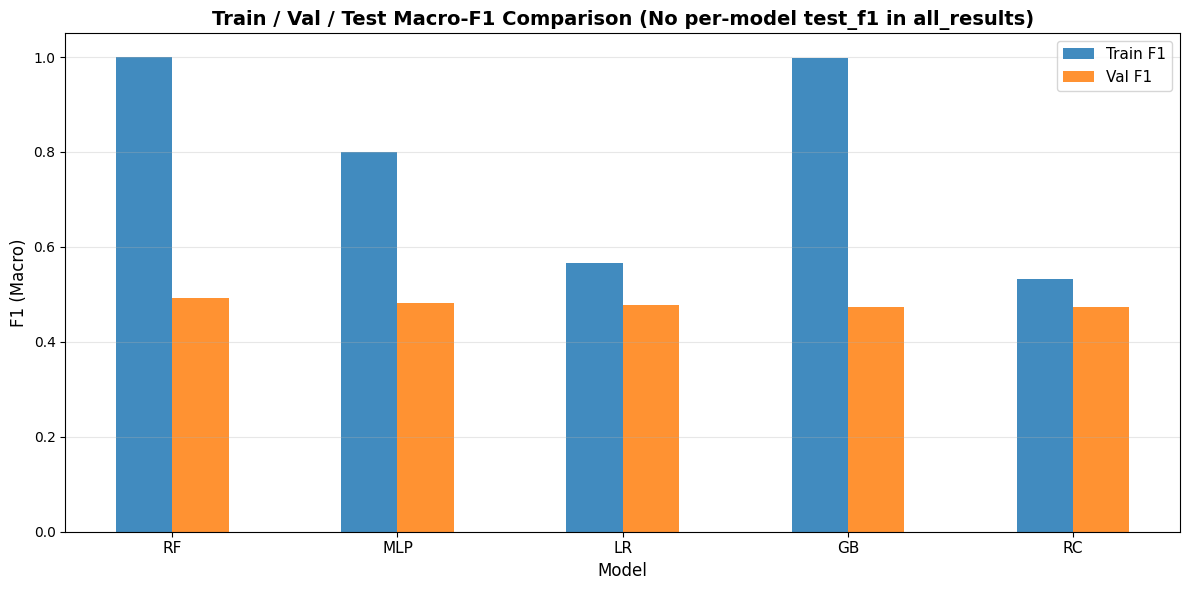

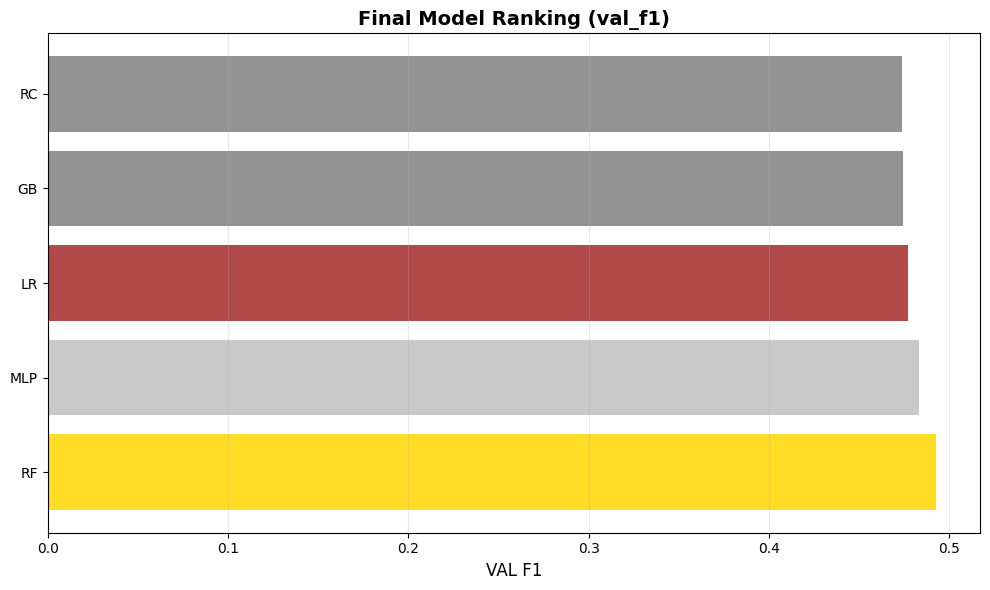

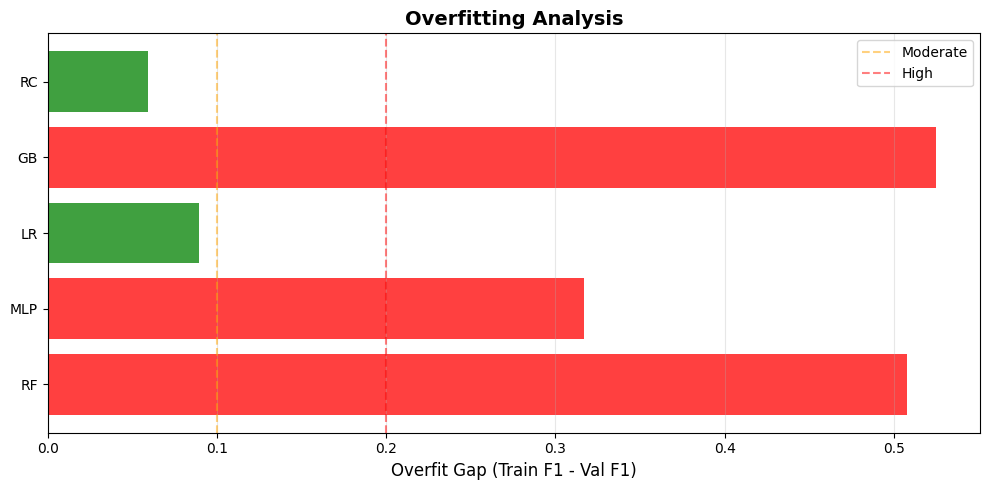


Uyarı: Aşağıdaki değişkenler yok; rapor/CM/split özet kısmı atlanacak:
['pred_test_best', 'best_final_name']

✅ TÜM ANALIZLER TAMAMLANDI!
🏆 En iyi model (Rank metric: val_f1): RF
   val_f1: 0.4924

📁 Tüm grafikler 'figures/' klasörüne kaydedildi.

Notebook çalıştırması başarıyla tamamlandı!


In [18]:
# ============================
# Sunum için tablolar ve grafikler (ROBUST / FIXED CELL)
# ============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------
# 0) Güvenlik: all_results var mı?
# ----------------------------
if "all_results" not in globals():
    raise NameError("all_results bulunamadı. Bu hücreden önce model sonuçlarını üreten hücreyi çalıştırın.")

# ----------------------------
# 1) DataFrame oluştur + kolonları normalize et
# ----------------------------
df_all_results = pd.DataFrame(all_results)

if df_all_results.empty:
    raise ValueError("all_results boş görünüyor. Model sonuçlarını gerçekten eklediğinizden emin olun.")

# Kolon isimlerini standardize et
df_all_results.columns = (
    df_all_results.columns.astype(str)
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# Yaygın varyasyonları standard kolonlara map et
rename_map = {
    # model adı
    "model_name": "model",
    "modelname": "model",
    "name": "model",

    # train f1 varyasyonları
    "train_macro_f1": "train_f1",
    "train_f1_score": "train_f1",
    "f1_train": "train_f1",
    "macro_f1_train": "train_f1",

    # val f1 varyasyonları
    "val_macro_f1": "val_f1",
    "validation_f1": "val_f1",
    "valid_f1": "val_f1",
    "val_f1_score": "val_f1",
    "f1_val": "val_f1",
    "macro_f1_val": "val_f1",

    # test f1 varyasyonları
    "test_macro_f1": "test_f1",
    "test_f1_score": "test_f1",
    "f1_test": "test_f1",
    "macro_f1_test": "test_f1",

    # accuracy varyasyonları
    "test_accuracy": "test_acc",
    "accuracy_test": "test_acc",
    "acc_test": "test_acc",
    "val_accuracy": "val_acc",
    "validation_acc": "val_acc",
    "train_accuracy": "train_acc",

    # overfit gap varyasyonları
    "overfitgap": "overfit_gap",
    "train_val_gap": "overfit_gap",
}
df_all_results.rename(columns=rename_map, inplace=True)

def autodetect_and_rename(df: pd.DataFrame, target: str, keywords: list[str]) -> None:
    """Kolon adı tam uyuşmazsa, keyword içeren tek bir kolon varsa onu rename et."""
    if target in df.columns:
        return
    cands = [c for c in df.columns if all(k in c for k in keywords)]
    if len(cands) == 1:
        df.rename(columns={cands[0]: target}, inplace=True)

autodetect_and_rename(df_all_results, "train_f1", ["train", "f1"])
autodetect_and_rename(df_all_results, "val_f1",   ["val", "f1"])
autodetect_and_rename(df_all_results, "test_f1",  ["test", "f1"])
autodetect_and_rename(df_all_results, "train_acc", ["train", "acc"])
autodetect_and_rename(df_all_results, "val_acc",   ["val", "acc"])
autodetect_and_rename(df_all_results, "test_acc",  ["test", "acc"])
autodetect_and_rename(df_all_results, "overfit_gap", ["overfit", "gap"])

# overfit_gap yoksa üret
if "overfit_gap" not in df_all_results.columns and {"train_f1", "val_f1"}.issubset(df_all_results.columns):
    df_all_results["overfit_gap"] = df_all_results["train_f1"] - df_all_results["val_f1"]

# Zorunlu kolon kontrolü (test_f1 artık zorunlu değil)
required_core = ["model", "train_f1", "val_f1"]
missing_core = [c for c in required_core if c not in df_all_results.columns]
if missing_core:
    print("Mevcut kolonlar:", df_all_results.columns.tolist())
    raise KeyError(
        f"Eksik çekirdek kolon(lar): {missing_core}. "
        "all_results içine bu metrikler yazılmıyor veya isimleri farklı. "
        "Mevcut kolon listesine göre rename_map'e ekleyebiliriz."
    )

# test_f1 yoksa kolonu ekle (NaN) ve uyarı bas
if "test_f1" not in df_all_results.columns:
    df_all_results["test_f1"] = np.nan
    print("Uyarı: all_results içinde 'test_f1' yok. Sıralama/özet için val_f1 veya selection_score kullanılacak.")
elif df_all_results["test_f1"].isna().all():
    print("Uyarı: 'test_f1' kolonu var ama tüm değerler NaN. Sıralama/özet için val_f1 veya selection_score kullanılacak.")

# Sıralama metriğini otomatik seç
def choose_rank_metric(df: pd.DataFrame) -> str:
    if "test_f1" in df.columns and not df["test_f1"].isna().all():
        return "test_f1"
    if "val_f1" in df.columns and not df["val_f1"].isna().all():
        return "val_f1"
    if "selection_score" in df.columns and not df["selection_score"].isna().all():
        return "selection_score"
    return "train_f1"

rank_metric = choose_rank_metric(df_all_results)

# Sırala
df_all_results = df_all_results.sort_values(rank_metric, ascending=False).reset_index(drop=True)

# Gösterilecek kolonları düzenle
preferred_cols = [
    "model", "train_f1", "val_f1", "test_f1",
    "train_acc", "val_acc", "test_acc",
    "val_bal_acc", "overfit_gap",
    "penalty", "selection_score"
]
show_cols = [c for c in preferred_cols if c in df_all_results.columns]
df_show = df_all_results[show_cols].copy()

print(f"\n📊 COMPLETE MODEL COMPARISON (Rank by: {rank_metric})")
display(df_show)

# ----------------------------
# 2) Grafik ayarları
# ----------------------------
SAVE_FIGS = True
FIG_DIR = "figures"
if SAVE_FIGS:
    os.makedirs(FIG_DIR, exist_ok=True)

# ----------------------------
# 3) Train / Val / Test F1 karşılaştırma
#    - test_f1 yoksa Train/Val çizer
# ----------------------------
has_test_f1 = ("test_f1" in df_all_results.columns) and (not df_all_results["test_f1"].isna().all())

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df_all_results))
width = 0.25

ax.bar(x - width/2, df_all_results["train_f1"], width, label="Train F1", alpha=0.85)
ax.bar(x + width/2, df_all_results["val_f1"],   width, label="Val F1",   alpha=0.85)

if has_test_f1:
    ax.bar(x + 1.5*width, df_all_results["test_f1"], width, label="Test F1", alpha=0.85)

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("F1 (Macro)", fontsize=12)
title_extra = " (Test available)" if has_test_f1 else " (No per-model test_f1 in all_results)"
ax.set_title("Train / Val / Test Macro-F1 Comparison" + title_extra, fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_all_results["model"].astype(str).str.upper(), fontsize=11, rotation=0)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, "train_val_test_comparison.png"), dpi=200, bbox_inches="tight")
plt.show()

# ----------------------------
# 4) Ranking grafiği (rank_metric ile)
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))
values = df_all_results[rank_metric].astype(float)

# Top-3 renklendirme (opsiyonel; metrik yoksa da çalışır)
colors_rank = ['gold' if i == 0 else 'silver' if i == 1 else 'brown' if i == 2 else 'gray'
               for i in range(len(df_all_results))]

ax.barh(df_all_results["model"].astype(str).str.upper(), values, color=colors_rank, alpha=0.85)
ax.set_xlabel(rank_metric.replace("_", " ").upper(), fontsize=12)
ax.set_title(f"Final Model Ranking ({rank_metric})", fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, f"model_ranking_{rank_metric}.png"), dpi=200, bbox_inches="tight")
plt.show()

# ----------------------------
# 5) Overfit analizi (Train - Val gap)
# ----------------------------
if "overfit_gap" not in df_all_results.columns:
    print("Uyarı: overfit_gap bulunamadı; overfit grafiği atlanıyor.")
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['green' if v < 0.1 else 'orange' if v < 0.2 else 'red' for v in df_all_results["overfit_gap"]]
    ax.barh(df_all_results["model"].astype(str).str.upper(), df_all_results["overfit_gap"], color=colors, alpha=0.75)
    ax.set_xlabel("Overfit Gap (Train F1 - Val F1)", fontsize=12)
    ax.set_title("Overfitting Analysis", fontsize=14, fontweight='bold')
    ax.axvline(0.1, color='orange', linestyle='--', alpha=0.5, label='Moderate')
    ax.axvline(0.2, color='red', linestyle='--', alpha=0.5, label='High')
    ax.legend(fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, "overfit_analysis.png"), dpi=200, bbox_inches="tight")
    plt.show()

# ----------------------------
# 6) Test set classification report (BEST MODEL)
# ----------------------------
# Aşağıdakiler önceki hücrelerden gelmeli:
needed_vars = [
    "y_test", "pred_test_best", "label_encoder", "best_final_name", "best_final",
    "grp_train", "grp_val", "grp_test", "X_train", "X_val", "X_test"
]
missing_vars = [v for v in needed_vars if v not in globals()]
if missing_vars:
    print("\nUyarı: Aşağıdaki değişkenler yok; rapor/CM/split özet kısmı atlanacak:")
    print(missing_vars)
else:
    report_dict = classification_report(
        y_test, pred_test_best,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )
    df_test_report = pd.DataFrame(report_dict).transpose()
    print("\n📋 TEST SET CLASSIFICATION REPORT (Best Model)")
    display(df_test_report)

    # ----------------------------
    # 7) Test set per-class F1 (BEST MODEL)
    # ----------------------------
    emotion_classes = [c for c in df_test_report.index if c not in ["accuracy", "macro avg", "weighted avg"]]
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(emotion_classes, df_test_report.loc[emotion_classes, "f1-score"], alpha=0.85)
    ax.set_xlabel("Emotion Class", fontsize=12)
    ax.set_ylabel("F1-score", fontsize=12)
    ax.set_title(f"Per-Class F1 on Test Set (Best Model: {str(best_final_name).upper()})",
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, "test_per_class_f1.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # ----------------------------
    # 8) Test set confusion matrix (BEST MODEL)
    # ----------------------------
    numeric_labels = sorted(np.unique(y_test))
    emotion_labels = [label_encoder.classes_[i] for i in numeric_labels]

    cm = confusion_matrix(y_test, pred_test_best, labels=numeric_labels)

    fig, ax = plt.subplots(figsize=(9, 8))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_xticks(range(len(emotion_labels)))
    ax.set_yticks(range(len(emotion_labels)))
    ax.set_xticklabels(emotion_labels, rotation=45, ha="right", fontsize=11)
    ax.set_yticklabels(emotion_labels, fontsize=11)
    ax.set_xlabel("Predicted", fontsize=12, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
    ax.set_title(f"Confusion Matrix (Test Set - {str(best_final_name).upper()})", fontsize=14, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color, fontsize=10)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, "confusion_matrix.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # ----------------------------
    # 9) Split özet tablosu (Train/Val/Test)
    # ----------------------------
    df_split = pd.DataFrame([
        {"set": "Train", "subjects": len(set(grp_train)), "samples": len(X_train)},
        {"set": "Val",   "subjects": len(set(grp_val)),   "samples": len(X_val)},
        {"set": "Test",  "subjects": len(set(grp_test)),  "samples": len(X_test)},
    ])
    print("\n📊 DATASET SPLIT SUMMARY")
    display(df_split)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.bar(df_split["set"], df_split["samples"], alpha=0.85)
    ax1.set_ylabel("Number of Samples", fontsize=11)
    ax1.set_title("Dataset Split (Samples)", fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for i, row in df_split.iterrows():
        ax1.text(i, row["samples"], str(row["samples"]), ha='center', va='bottom', fontsize=10)

    ax2.bar(df_split["set"], df_split["subjects"], alpha=0.85)
    ax2.set_ylabel("Number of Subjects", fontsize=11)
    ax2.set_title("Dataset Split (Subjects)", fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for i, row in df_split.iterrows():
        ax2.text(i, row["subjects"], str(row["subjects"]), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, "dataset_split.png"), dpi=200, bbox_inches="tight")
    plt.show()

# ----------------------------
# Final özet (rank_metric ile)
# ----------------------------
best_row = df_all_results.iloc[0]
best_model_name = str(best_row["model"]).upper()
best_metric_val = best_row[rank_metric]

print("\n" + "="*70)
print("✅ TÜM ANALIZLER TAMAMLANDI!")
print("="*70)
print(f"🏆 En iyi model (Rank metric: {rank_metric}): {best_model_name}")
try:
    if pd.notna(best_metric_val):
        print(f"   {rank_metric}: {float(best_metric_val):.4f}")
except Exception:
    pass

# Eğer best_final dict'inden test metrikleri varsa ayrıca bas
if "best_final" in globals() and isinstance(best_final, dict):
    if "test_acc" in best_final:
        print(f"   Test Accuracy: {best_final['test_acc']:.4f}")
    if "test_f1" in best_final:
        print(f"   Test Macro-F1: {best_final['test_f1']:.4f}")

print("="*70)
if SAVE_FIGS:
    print(f"\n📁 Tüm grafikler '{FIG_DIR}/' klasörüne kaydedildi.")
print("\nNotebook çalıştırması başarıyla tamamlandı!")


## 6b) Learning Curve & Loss (Log-Loss) Curves 


MODEL: rc


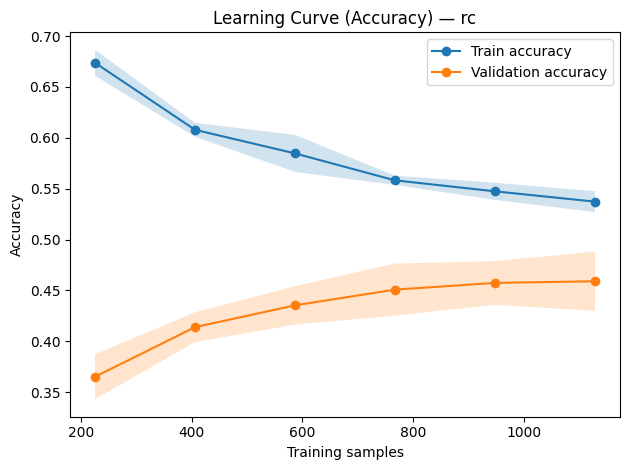

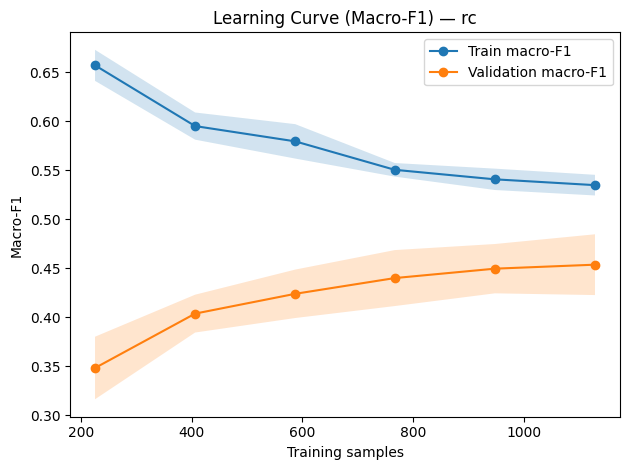

[SKIP] rc: predict_proba yok; log-loss grafiği çizilmedi.


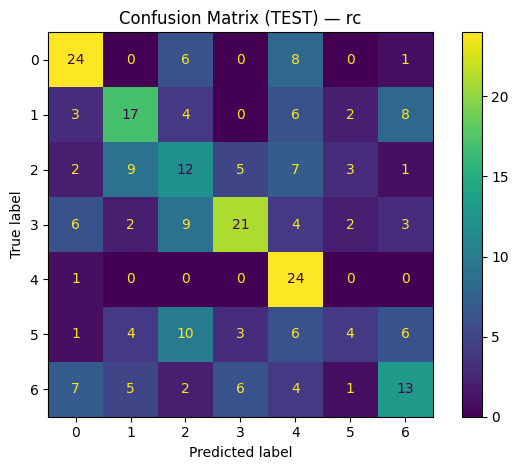


MODEL: gb


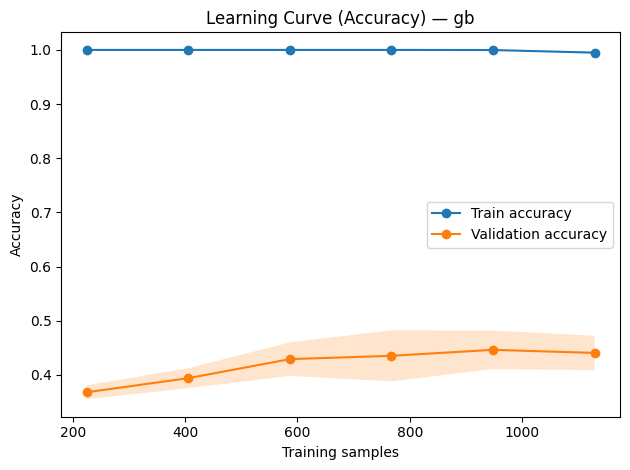

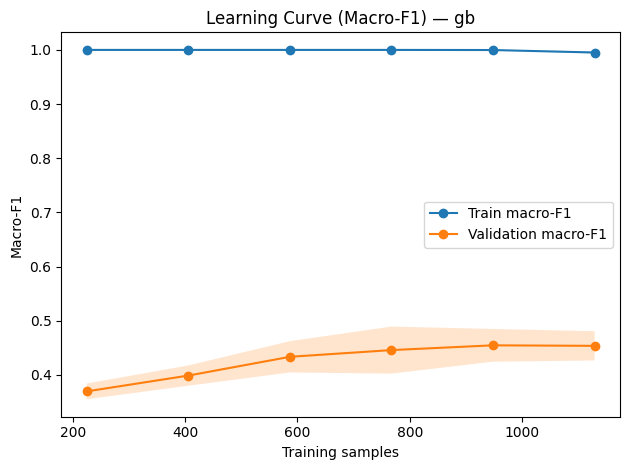

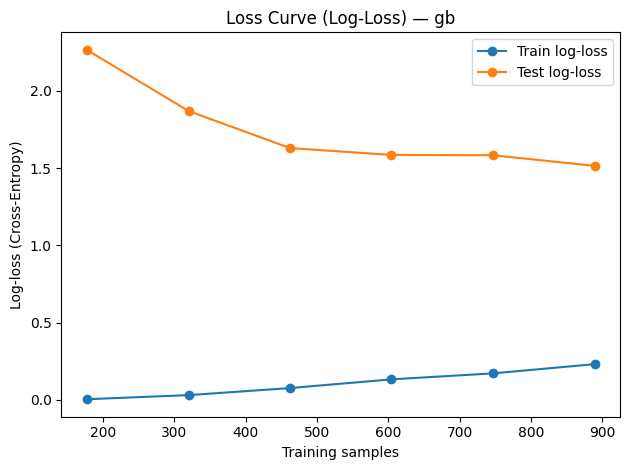

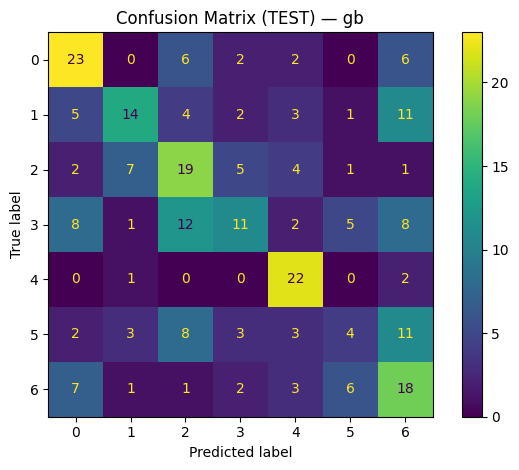


MODEL: rf


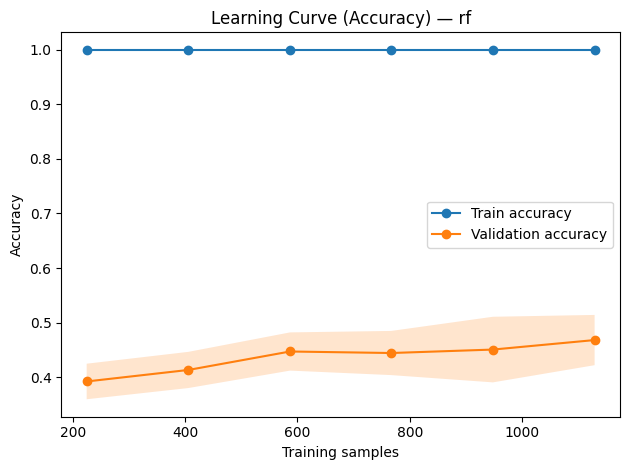

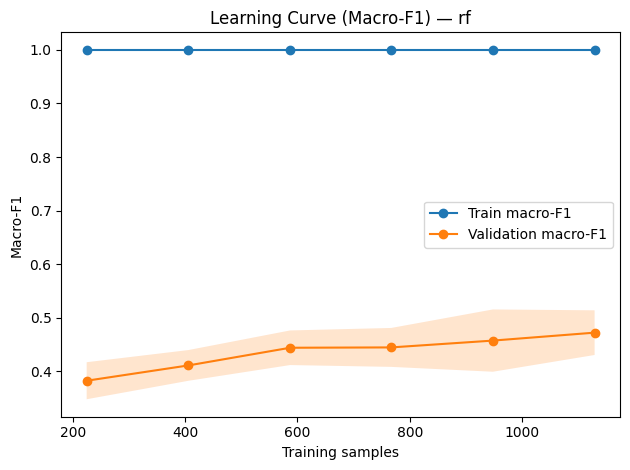

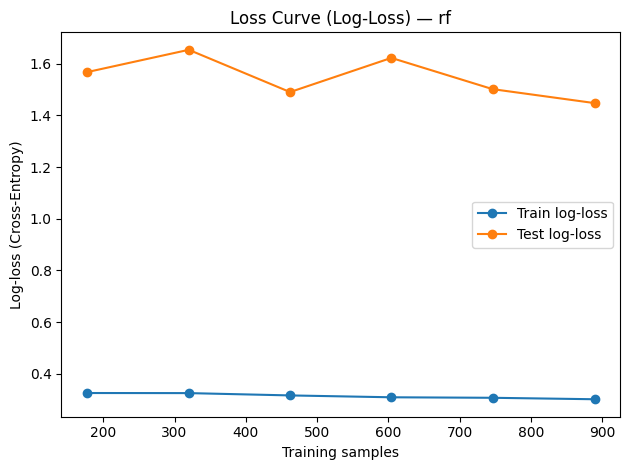

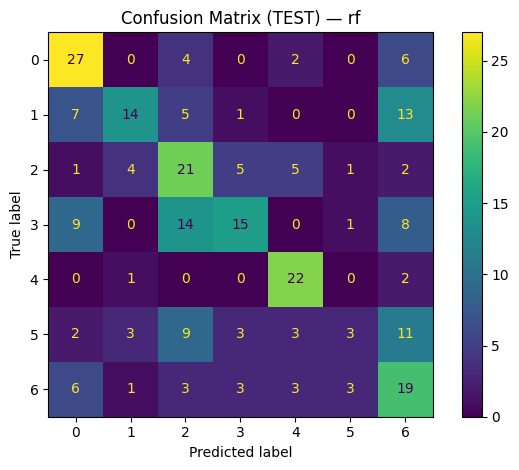


MODEL: mlp


/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

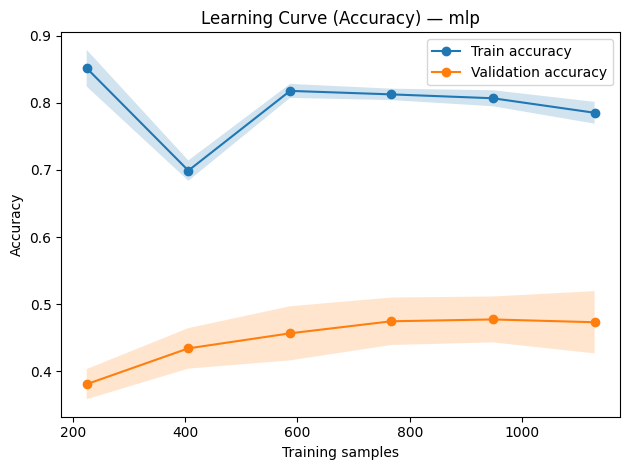

/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

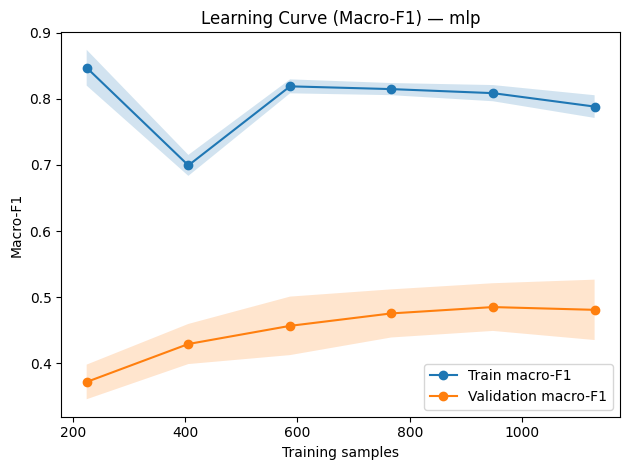

/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

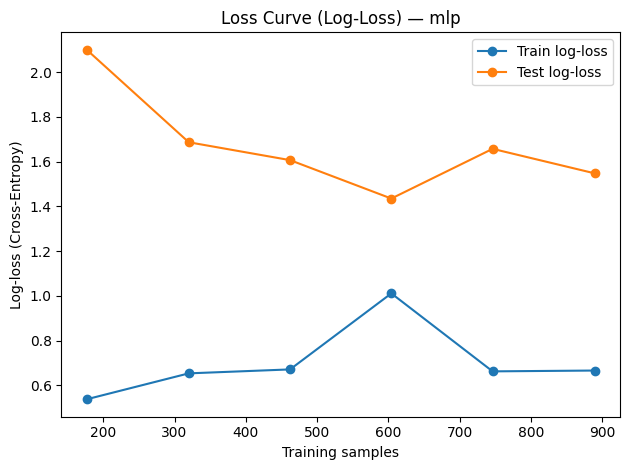

/Users/mehmetatahankulekci/Desktop/deneme/.venv312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


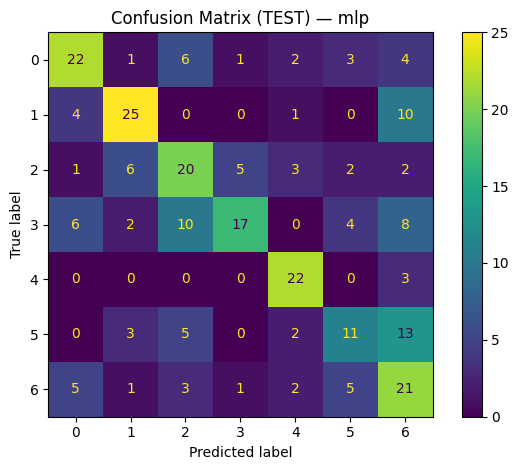

In [19]:
# ============================
# RC + GB + RF için Learning Curve + LogLoss + Confusion Matrix (ROBUST)
# ============================

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, learning_curve
from sklearn.base import clone
from sklearn.metrics import log_loss, ConfusionMatrixDisplay

# ----------------------------
# 0) Hangi modelleri istiyoruz?
# ----------------------------
MODEL_KEYS = ["rc", "gb", "rf", "mlp"]  # sende isimler farklıysa burada değiştir

# ----------------------------
# 1) Modelleri güvenli şekilde bul (best_models > fit_models > pipelines)
# ----------------------------
model_pool = {}
if "best_models" in globals() and isinstance(best_models, dict):
    model_pool.update(best_models)
if "fit_models" in globals() and isinstance(fit_models, dict):
    model_pool.update(fit_models)
if "pipelines" in globals() and isinstance(pipelines, dict):
    # pipelines fit edilmemiş olabilir ama learning_curve zaten fit edecek
    model_pool.update(pipelines)

missing = [k for k in MODEL_KEYS if k not in model_pool]
if missing:
    raise NameError(
        f"Bu modeller bulunamadı: {missing}\n"
        f"Mevcut model anahtarları: {sorted(list(model_pool.keys()))}\n"
        "MODEL_KEYS'i sende olan isimlerle güncelle veya ilgili dict'leri (pipelines/fit_models/best_models) üret."
    )

selected_models = {k: model_pool[k] for k in MODEL_KEYS}

# ----------------------------
# 2) X, y, groups yoksa splitlerden birleştir
# ----------------------------
if ("X" not in globals()) or ("y" not in globals()) or ("groups" not in globals()):
    needed = ["X_train","X_val","X_test","y_train","y_val","y_test","grp_train","grp_val","grp_test"]
    miss = [v for v in needed if v not in globals()]
    if miss:
        raise NameError(
            f"X/y/groups yok ve splitlerden birleştirmek için eksikler var: {miss}\n"
            "Ya X,y,groups tanımla ya da split değişkenlerini üret."
        )
    X = np.concatenate([np.asarray(X_train), np.asarray(X_val), np.asarray(X_test)], axis=0)
    y = np.concatenate([np.asarray(y_train), np.asarray(y_val), np.asarray(y_test)], axis=0)
    groups = np.concatenate([np.asarray(grp_train), np.asarray(grp_val), np.asarray(grp_test)], axis=0)

# ----------------------------
# 3) Kayıt ayarları
# ----------------------------
if "SAVE_FIGS" not in globals():
    SAVE_FIGS = True
if "FIG_DIR" not in globals():
    FIG_DIR = "figures"
if SAVE_FIGS:
    os.makedirs(FIG_DIR, exist_ok=True)

# ----------------------------
# 4) CV ve train size ayarları
# ----------------------------
cv = GroupKFold(n_splits=5)
train_sizes_frac = np.linspace(0.2, 1.0, 6)

# ----------------------------
# 5) Log-loss için yardımcılar
# ----------------------------
all_labels = np.unique(y)

def _align_proba(model, proba, all_labels):
    """Modelin olası sınıf kolonlarını tüm label setine hizalar."""
    model_labels = model.classes_
    out = np.zeros((proba.shape[0], len(all_labels)), dtype=float)
    for i, lab in enumerate(model_labels):
        j = np.where(all_labels == lab)[0]
        if len(j) == 1:
            out[:, j[0]] = proba[:, i]
    row_sum = out.sum(axis=1, keepdims=True)
    out = np.where(row_sum > 0, out / row_sum, 1.0 / len(all_labels))
    return out

# Train lokal set (log-loss size subsampling için)
if ("X_train" in globals()) and ("y_train" in globals()):
    X_train_local = np.asarray(X_train)
    y_train_local = np.asarray(y_train)
else:
    X_train_local = np.asarray(X)
    y_train_local = np.asarray(y)

has_test = ("X_test" in globals()) and ("y_test" in globals())
has_val  = ("X_val" in globals()) and ("y_val" in globals())

# ----------------------------
# 6) Çizimler ve Confusion Matrix
# ----------------------------
for name, est in selected_models.items():
    print("\n" + "="*90)
    print(f"MODEL: {name}")
    print("="*90)

    # ---- Learning Curve: Accuracy ----
    train_sizes_abs, train_scores_acc, val_scores_acc = learning_curve(
        clone(est),
        X, y,
        groups=groups,
        cv=cv,
        train_sizes=train_sizes_frac,
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = train_scores_acc.mean(axis=1)
    train_std  = train_scores_acc.std(axis=1)
    val_mean   = val_scores_acc.mean(axis=1)
    val_std    = val_scores_acc.std(axis=1)

    plt.figure()
    plt.plot(train_sizes_abs, train_mean, marker="o", label="Train accuracy")
    plt.plot(train_sizes_abs, val_mean, marker="o", label="Validation accuracy")
    plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve (Accuracy) — {name}")
    plt.legend()
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"learning_curve_accuracy_{name}.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # ---- Learning Curve: Macro-F1 ----
    train_sizes_abs, train_scores_f1, val_scores_f1 = learning_curve(
        clone(est),
        X, y,
        groups=groups,
        cv=cv,
        train_sizes=train_sizes_frac,
        scoring="f1_macro",
        n_jobs=-1
    )

    train_mean = train_scores_f1.mean(axis=1)
    train_std  = train_scores_f1.std(axis=1)
    val_mean   = val_scores_f1.mean(axis=1)
    val_std    = val_scores_f1.std(axis=1)

    plt.figure()
    plt.plot(train_sizes_abs, train_mean, marker="o", label="Train macro-F1")
    plt.plot(train_sizes_abs, val_mean, marker="o", label="Validation macro-F1")
    plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.xlabel("Training samples")
    plt.ylabel("Macro-F1")
    plt.title(f"Learning Curve (Macro-F1) — {name}")
    plt.legend()
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"learning_curve_macro_f1_{name}.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # ---- Loss curve (Log-Loss) ----
    if hasattr(est, "predict_proba"):
        rng = np.random.default_rng(42)
        perm = rng.permutation(len(X_train_local))

        sizes = [max(50, int(len(X_train_local) * f)) for f in train_sizes_frac]
        sizes = sorted(set([min(s, len(X_train_local)) for s in sizes]))

        train_losses = []
        test_losses = []

        for n in sizes:
            sub_idx = perm[:n]
            m = clone(est)
            m.fit(X_train_local[sub_idx], y_train_local[sub_idx])

            proba_train = _align_proba(m, m.predict_proba(X_train_local[sub_idx]), all_labels)
            train_losses.append(log_loss(y_train_local[sub_idx], proba_train, labels=all_labels))

            if has_test:
                proba_test = _align_proba(m, m.predict_proba(np.asarray(X_test)), all_labels)
                test_losses.append(log_loss(np.asarray(y_test), proba_test, labels=all_labels))

        plt.figure()
        plt.plot(sizes, train_losses, marker="o", label="Train log-loss")
        if has_test:
            plt.plot(sizes, test_losses, marker="o", label="Test log-loss")
        plt.xlabel("Training samples")
        plt.ylabel("Log-loss (Cross-Entropy)")
        plt.title(f"Loss Curve (Log-Loss) — {name}")
        plt.legend()
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(os.path.join(FIG_DIR, f"loss_curve_logloss_{name}.png"), dpi=200, bbox_inches="tight")
        plt.show()
    else:
        print(f"[SKIP] {name}: predict_proba yok; log-loss grafiği çizilmedi.")

    # ---- Confusion Matrix (önce TEST, yoksa VAL) ----
    m_full = clone(est)

    if has_test:
        m_full.fit(np.asarray(X_train), np.asarray(y_train))
        y_true = np.asarray(y_test)
        y_pred = m_full.predict(np.asarray(X_test))
        cm_title = f"Confusion Matrix (TEST) — {name}"
        cm_file = f"confusion_matrix_test_{name}.png"
    elif has_val:
        m_full.fit(np.asarray(X_train), np.asarray(y_train))
        y_true = np.asarray(y_val)
        y_pred = m_full.predict(np.asarray(X_val))
        cm_title = f"Confusion Matrix (VAL) — {name}"
        cm_file = f"confusion_matrix_val_{name}.png"
    else:
        # son çare: tüm veri üzerinde (çok anlamlı değil ama hata vermesin)
        m_full.fit(np.asarray(X), np.asarray(y))
        y_true = np.asarray(y)
        y_pred = m_full.predict(np.asarray(X))
        cm_title = f"Confusion Matrix (ALL DATA) — {name}"
        cm_file = f"confusion_matrix_all_{name}.png"

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    ax.set_title(cm_title)
    fig.tight_layout()
    if SAVE_FIGS:
        fig.savefig(os.path.join(FIG_DIR, cm_file), dpi=200, bbox_inches="tight")
    plt.show()


In [20]:
[k for k in globals().keys() if isinstance(globals()[k], __import__("pandas").DataFrame)]


['results_df', 'df_all_results', 'df_show']

In [21]:
sorted([k for k in globals().keys() if k.startswith("X") or "group" in k.lower() or k in ["y", "y_all", "X", "groups"]])


['GroupKFold',
 'GroupShuffleSplit',
 'StratifiedGroupKFold',
 'X',
 'X_test',
 'X_train',
 'X_train_local',
 'X_trainval',
 'X_val',
 'groups',
 'y']

In [22]:
print("Sınıflar:", sorted(set(y)))


Sınıflar: [0, 1, 2, 3, 4, 5, 6]


In [31]:
# =========================
# 9) "GERÇEK ZAMANLI" TEST (RC) 
# =========================

import numpy as np
import pandas as pd

try:
    from IPython.display import display
except Exception:
    display = print

from sklearn.base import clone

# --- gerekli değişkenler ---
required = ["X_train", "y_train", "X_test", "y_test", "label_mapping"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Eksik değişken(ler): {missing}. Bu hücreyi split + feature + training sonrası çalıştır.")

# dataset meta (sample_id/subject/label) varsa al
DATASET_ROWS = globals().get("DATASET_ROWS")

# --- RC pipeline/template bul ---
rc_template = None
if "best_models" in globals() and isinstance(best_models, dict) and "rc" in best_models:
    rc_template = best_models["rc"]
elif "fit_models" in globals() and isinstance(fit_models, dict) and "rc" in fit_models:
    rc_template = fit_models["rc"]
elif "pipelines" in globals() and isinstance(pipelines, dict) and "rc" in pipelines:
    rc_template = pipelines["rc"]
elif "base_pipelines" in globals() and isinstance(base_pipelines, dict) and "rc" in base_pipelines:
    rc_template = base_pipelines["rc"]
else:
    raise NameError("RC modeli bulunamadı. best_models/fit_models/pipelines/base_pipelines içinde 'rc' yok.")

# --- RC modeli eğit (olasılık/eminlik göstermiyoruz) ---
rc_model = clone(rc_template)
rc_model.fit(np.asarray(X_train), np.asarray(y_train))

# --- random seçim ---

import time
rng = np.random.default_rng(time.time_ns() % (2**63 - 1))

# subject'i en sağlam şekilde grp_test'ten alabiliriz
has_grp_test = ("grp_test" in globals()) and (len(globals()["grp_test"]) == len(X_test))

# global index varsa sample_id için kullan
has_test_idx = ("test_idx" in globals()) and (len(globals()["test_idx"]) == len(X_test))

rows_is_dataset = (
    isinstance(DATASET_ROWS, list)
    and len(DATASET_ROWS) > 0
    and isinstance(DATASET_ROWS[0], dict)
    and ("sample_id" in DATASET_ROWS[0])
)


k_try = int(min(10, len(X_test)))
candidates = rng.choice(len(X_test), size=k_try, replace=False)

y_test_arr = np.asarray(y_test)
preds = rc_model.predict(np.asarray(X_test)[candidates])

correct_idx = [int(candidates[i]) for i in range(len(candidates)) if int(preds[i]) == int(y_test_arr[int(candidates[i])])]
wrong_idx   = [int(candidates[i]) for i in range(len(candidates)) if int(preds[i]) != int(y_test_arr[int(candidates[i])])]


if (len(correct_idx) < 2) or (len(wrong_idx) < 1):
    rest = np.setdiff1d(np.arange(len(X_test)), candidates)
    extra = rest[: min(200, len(rest))]
    if len(extra) > 0:
        extra = rng.choice(extra, size=len(extra), replace=False)
        extra_preds = rc_model.predict(np.asarray(X_test)[extra])
        for i, li in enumerate(extra):
            li = int(li)
            if int(extra_preds[i]) == int(y_test_arr[li]):
                correct_idx.append(li)
            else:
                wrong_idx.append(li)
            if (len(correct_idx) >= 2) and (len(wrong_idx) >= 1):
                break

# havuzdan rastgele seç (hep ilk elemanları alma)
picked = []
if len(correct_idx) >= 2:
    picked += rng.choice(np.array(correct_idx, dtype=int), size=2, replace=False).tolist()
if len(wrong_idx) >= 1:
    picked += rng.choice(np.array(wrong_idx, dtype=int), size=1, replace=False).tolist()

if len(picked) < 3:
    raise RuntimeError(f" Bulunan doğru={len(correct_idx)}, yanlış={len(wrong_idx)}")

rows_out = []
for urun_no, local_i in enumerate(picked, start=1):
    local_i = int(local_i)
    global_i = int(globals()["test_idx"][local_i]) if has_test_idx else None

    sample_id = str(local_i)
    if (global_i is not None) and rows_is_dataset and (0 <= global_i < len(DATASET_ROWS)):
        sample_id = DATASET_ROWS[global_i].get("sample_id", str(global_i))

    subject = str(globals()["grp_test"][local_i]) if has_grp_test else "UNK"

    y_true = int(y_test_arr[local_i])
    y_pred = int(rc_model.predict(np.asarray(X_test)[local_i].reshape(1, -1))[0])

    true_label = str(label_mapping.get(y_true, y_true))
    pred_label = str(label_mapping.get(y_pred, y_pred))

    rows_out.append({
        "urun": urun_no,
        "sample_id": sample_id,
        "subject": subject,
        "true": true_label,
        "pred": pred_label,
    })

rt_df = pd.DataFrame(rows_out)
display(rt_df)


for r in rows_out:
    tag = "DOĞRU" if (r["pred"] == r["true"]) else "YANLIŞ"
    print(f"[{r['urun']}] {tag}: pred={r['pred']} | true={r['true']} | subject={r['subject']} | sample_id={r['sample_id']}")



,urun,sample_id,subject,true,pred
0,1,35,M02,happy,happy
1,2,148,M04,fear,fear
2,3,176,M04,happy,fear


[1] DOĞRU: pred=happy | true=happy | subject=M02 | sample_id=35
[2] DOĞRU: pred=fear | true=fear | subject=M04 | sample_id=148
[3] YANLIŞ: pred=fear | true=happy | subject=M04 | sample_id=176
